<a href="https://colab.research.google.com/github/TartaMan01/blank-app-template-5x7e84quo9n/blob/main/NBI_ImageAnalysis_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless'
os.chdir(directory)
print(os.getcwd())

/content/drive/MyDrive/NBI_OralCancer_Nameless


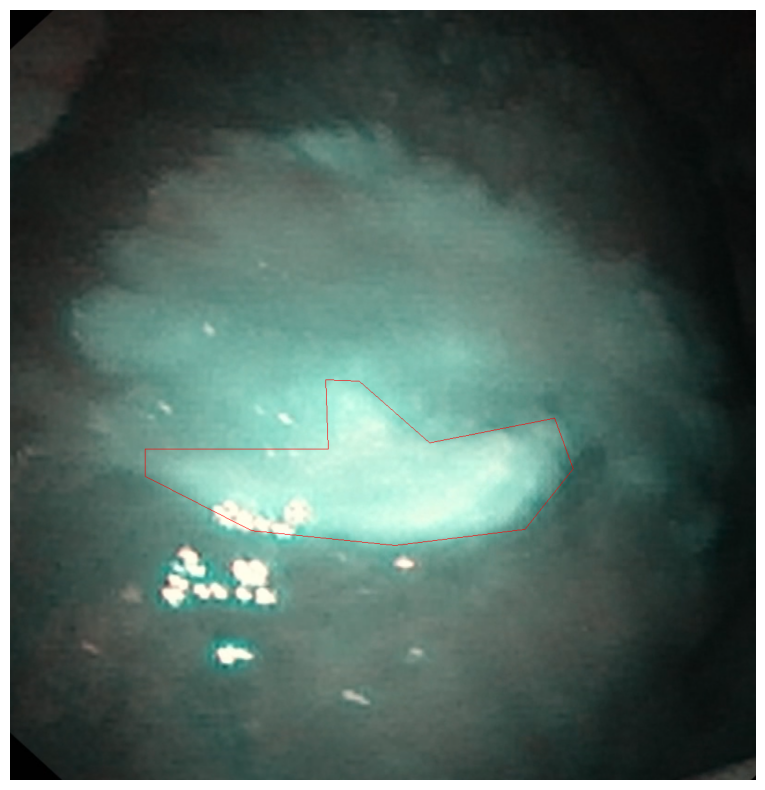

In [4]:
## CHECK THAT THE FILE IS CORRECT AND ROI WORKS WITH SAMPLE ##
import json
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt


json_path = '/content/drive/MyDrive/NBI_OralCancer_Nameless/Paz12.7.json'
with open(json_path, 'r') as file:
     data = json.load(file)

image_path = '/content/drive/MyDrive/NBI_OralCancer_Nameless/Paz12.7.png'
image = Image.open(image_path)

draw = ImageDraw.Draw(image)

# Iterate over each shape to draw the polygons
for shape in data['shapes']:
    points = shape['points']
    points_tuple = [(point[0], point[1]) for point in points]
    draw.polygon(points_tuple, outline='red')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
annotated_ROI_directory = os.path.join(directory, "annotated_ROI_images")
# Ensurin the directory for annotated ROI images exists
if not os.path.exists(annotated_ROI_directory):
    os.makedirs(annotated_ROI_directory)

png_filenames = set(f for f in os.listdir(directory) if f.endswith('.png'))
json_filenames = set(f for f in os.listdir(directory) if f.endswith('.json'))

jsons_without_png = {f for f in json_filenames if f.replace('.json', '.png') not in png_filenames}
png_without_json ={j for j in png_filenames if j.replace('.png','.json') not in json_filenames}

# Print JSON filenames that don't have corresponding PNG files
for json_file in jsons_without_png:
    print(f"No corresponding PNG file found for: {json_file}")
for png_file in png_without_json:
  print(f"No corresponding JSON file found for: {png_file}")

# Loop through PNG files and process them
for filename in png_filenames:
    try:
        image_path = os.path.join(directory, filename)
        json_path = os.path.join(directory, os.path.splitext(filename)[0] + '.json')

        if os.path.exists(json_path):
            image = Image.open(image_path)
            draw = ImageDraw.Draw(image)

            with open(json_path, 'r') as f:
                data = json.load(f)

            for shape in data['shapes']:
                polygon_points = [tuple(point) for point in shape['points']]
                draw.polygon(polygon_points, outline='red')

            annotated_image_path = os.path.join(annotated_ROI_directory, 'annotated_' + filename)
            image.save(annotated_image_path)
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

print("Annotation completed for all images.")

KeyboardInterrupt: 

#Creation of ROIs

In [ ]:
import json
import os
from PIL import Image, ImageDraw

# Path to the directory containing the JSON and PNG files
directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless'
ROI_directory = os.path.join(directory, 'ROIs')

# Ensure the ROI directory is created
os.makedirs(ROI_directory, exist_ok=True)

# Collect all PNG filenames
png_filenames = set(f for f in os.listdir(directory) if f.endswith('.png'))

# Loop through PNG files and process them
for filename in png_filenames:
    image_path = os.path.join(directory, filename)
    json_path = os.path.join(directory, os.path.splitext(filename)[0] + '.json')

    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)

        image = Image.open(image_path)
        mask = Image.new('L', (image.width, image.height), 0)
        draw = ImageDraw.Draw(mask)

        # Process each shape specified in the JSON
        for shape in data['shapes']:
            polygon_points = [tuple(point) for point in shape['points']]
            draw.polygon(polygon_points, outline=1, fill=255)

        # Apply mask to the image
        roi = Image.new('RGBA', (image.width, image.height))
        roi.paste(image, mask=mask)

        # Save the ROI image that only includes the area inside the polygon
        roi_image_path = os.path.join(ROI_directory, 'ROI_' + filename)
        roi.save(roi_image_path)

print("Annotation and ROI extraction completed for all applicable images.")

In [ ]:
pip install opencv-python-headless numpy

In [ ]:
pip install scikit-image numpy

##Only Anisotropic Diffusion


In [ ]:
import os
from skimage import io, restoration
import numpy as np

ROI_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs'
anisotropicDiffused_dir= os.path.join(ROI_directory, 'AnisotropicDiffused')
os.makedirs(anisotropicDiffused_dir, exist_ok=True)

for filename in os.listdir(ROI_directory):
    if filename.endswith('.png'):
        image_path = os.path.join(ROI_directory, filename)
        image = io.imread(image_path)

        # Check if the image is not in grayscale (expects a color image)
        if image.ndim == 3 and image.shape[2] == 4:  # RGBA
            image = image[..., :3]

        # Apply anisotropic diffusion (Perona-Malik filter)
        filtered_image = restoration.denoise_nl_means(image, multichannel=True)

#skimage.restoration.denoise_nl_means is used here as a proxy to demonstrate noise reduction which is somewhat similar in intent to anisotropic diffusion.
#If we strictly need Perona-Malik implementation, we might need to use restoration.denoise_tv_chambolle which is closer to actual anisotropic diffusion.

        # Save the filtered image
        filtered_image_path = os.path.join(anisotropicDiffused_dir, 'AnisoDiff_' + filename)
        io.imsave(filtered_image_path, (filtered_image * 255).astype(np.uint8))  # Convert back to uint8

print("Anisotropic diffusion applied to all applicable images.")

<ipython-input-20-c3e02eb6c0d6>:19: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  filtered_image = restoration.denoise_nl_means(image, multichannel=True)


Processed and saved filtered image for ROI_Paz16.3.png
Processed and saved filtered image for ROI_Paz4.2.png
Processed and saved filtered image for ROI_Paz_23.1.png
Processed and saved filtered image for ROI_Paz4.1.png
Processed and saved filtered image for ROI_Paz12.7.png
Processed and saved filtered image for ROI_Paz_24.1.png
Processed and saved filtered image for ROI_Paz7.4.png
Processed and saved filtered image for ROI_Paz_23.4.png
Processed and saved filtered image for ROI_Paz_20.2.png
Processed and saved filtered image for ROI_Paz14.3.png
Processed and saved filtered image for ROI_Paz5.5.png
Processed and saved filtered image for ROI_Paz16.6.png
Processed and saved filtered image for ROI_Paz_26.1.png
Processed and saved filtered image for ROI_Paz_25.4.png
Processed and saved filtered image for ROI_Paz_26.2.png
Processed and saved filtered image for ROI_Paz16.1.png
Processed and saved filtered image for ROI_Paz12.1.png
Processed and saved filtered image for ROI_Paz4.3.png
Processe

 ## CLAHE, Sharpen, Median, then Anisotropic

In [ ]:
# import os
# import numpy as np
# from skimage import io, restoration, img_as_ubyte, img_as_float
# from skimage.filters import median, unsharp_mask
# from skimage.morphology import disk
# import cv2  # For CLAHE

# # Directory containing the ROI images
# ROI_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs'
# anisotropicDiffused_dir = os.path.join(ROI_directory, 'Process_Then_AnisotropicDiffused')
# os.makedirs(anisotropicDiffused_dir, exist_ok=True)  # Ensure the directory is created

# # Loop through each image in the ROI directory
# for filename in os.listdir(ROI_directory):
#     if filename.endswith('.png'):
#         image_path = os.path.join(ROI_directory, filename)
#         image = io.imread(image_path)

#         # Convert to RGB if it is RGBA
#         if image.ndim == 3 and image.shape[2] == 4:
#             image = image[..., :3]

#         # Apply CLAHE to improve the contrast
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#         if image.ndim == 3:  # For RGB images
#             image = cv2.merge([clahe.apply(img_as_ubyte(channel)) for channel in cv2.split(image)])
#         else:
#             image = clahe.apply(img_as_ubyte(image))

#         # Convert to uint8 for median filter
#         image = img_as_ubyte(image)

#         # Apply sharpening filter
#         image = unsharp_mask(image, radius=1, amount=1)

#         # Apply median filter
#         if image.ndim == 3:  # Check if multi-channel and apply accordingly
#             image = np.stack([median(channel, disk(3)) for channel in np.rollaxis(image, -1)], axis=-1)
#         else:
#             image = median(image, disk(3))

#         # Convert to float and ensure the range is 0 to 1 for anisotropic diffusion
#         image = img_as_float(image)

#         # Apply anisotropic diffusion (denoise_tv_chambolle)
#         filtered_image = restoration.denoise_tv_chambolle(image, weight=0.1, multichannel=True)

#         # Save the filtered image to the new directory
#         filtered_image_path = os.path.join(anisotropicDiffused_dir, 'Processed_' + filename)
#         io.imsave(filtered_image_path, img_as_ubyte(filtered_image))  # Convert back to uint8

# print("All applicable images have been processed with preprocessing and anisotropic diffusion.")

<ipython-input-23-2352acf14a32>:46: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  filtered_image = restoration.denoise_tv_chambolle(image, weight=0.1, multichannel=True)


All applicable images have been processed with preprocessing and anisotropic diffusion.


In [ ]:
# import os
# import numpy as np
# from skimage import io, restoration, img_as_ubyte, img_as_float, color
# from skimage.filters import median, unsharp_mask
# from skimage.morphology import disk
# import cv2  # For CLAHE

# # Directory containing the ROI images
# ROI_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs'
# anisotropicDiffused_dir = os.path.join(ROI_directory, 'processing_Attempt_2')
# os.makedirs(anisotropicDiffused_dir, exist_ok=True)  # Ensure the directory is created

# # Loop through each image in the ROI directory
# for filename in os.listdir(ROI_directory):
#     if filename.endswith('.png'):
#         image_path = os.path.join(ROI_directory, filename)
#         image = io.imread(image_path)

#         # Convert to RGB if it is RGBA
#         if image.ndim == 3 and image.shape[2] == 4:
#             image = image[..., :3]

#         # Apply CLAHE to improve the contrast
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#         if image.ndim == 3:  # For RGB images
#             image = cv2.merge([clahe.apply(img_as_ubyte(channel)) for channel in cv2.split(image)])
#         else:
#             image = clahe.apply(img_as_ubyte(image))

#         # Convert to grayscale
#         if image.ndim == 3:
#             image = color.rgb2gray(image)

#         # Convert to uint8 for median filter
#         image = img_as_ubyte(image)

#         # Apply sharpening filter
#         image = unsharp_mask(image, radius=1, amount=1)

#         # Apply median filter
#         image = median(image, disk(3))

#         # Convert to float and ensure the range is 0 to 1 for anisotropic diffusion
#         image = img_as_float(image)

#         # Apply anisotropic diffusion (denoise_tv_chambolle)
#         filtered_image = restoration.denoise_tv_chambolle(image, weight=0.1, multichannel=False)

#         # Save the filtered image to the new directory
#         filtered_image_path = os.path.join(anisotropicDiffused_dir, 'Processed_' + filename)
#         io.imsave(filtered_image_path, img_as_ubyte(filtered_image))  # Convert back to uint8

# print("All applicable images have been processed with preprocessing and anisotropic diffusion.")

<ipython-input-17-9b2c30ae33fd>:47: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  filtered_image = restoration.denoise_tv_chambolle(image, weight=0.1, multichannel=False)


All applicable images have been processed with preprocessing and anisotropic diffusion.


In [ ]:
import os
import numpy as np
from skimage import io, restoration, img_as_ubyte, img_as_float, color
from skimage.filters import median, unsharp_mask
from skimage.morphology import disk
import cv2  # For CLAHE

# Directory containing the ROI images
ROI_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs'
anisotropicDiffused_dir = os.path.join(ROI_directory, 'processing_Attempt_4')
os.makedirs(anisotropicDiffused_dir, exist_ok=True)  # Ensure the directory is created

# Loop through each image in the ROI directory
for filename in os.listdir(ROI_directory):
    if filename.endswith('.png'):
        image_path = os.path.join(ROI_directory, filename)
        image = io.imread(image_path)

        # Convert to RGB if it is RGBA
        if image.ndim == 3 and image.shape[2] == 4:
            image = image[..., :3]

        # Apply CLAHE to improve the contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        if image.ndim == 3:  # For RGB images
            image = cv2.merge([clahe.apply(img_as_ubyte(channel)) for channel in cv2.split(image)])
        else:
            image = clahe.apply(img_as_ubyte(image))

        # Convert to grayscale
        if image.ndim == 3:
            image = color.rgb2gray(image)

        # Convert to uint8 for median filter
        image = img_as_ubyte(image)

        # Apply sharpening filter
        image = unsharp_mask(image, radius=1, amount=1)

        # Apply median filter
        image = median(image, disk(3))

        # Convert to float and ensure the range is 0 to 1 for anisotropic diffusion
        image = img_as_float(image)

        # Apply anisotropic diffusion (denoise_tv_chambolle)
        filtered_image = restoration.denoise_tv_chambolle(image, weight=0.1, multichannel=False)

        filtered_image = clahe.apply(img_as_ubyte(filtered_image))
        filtered_image = unsharp_mask(filtered_image, radius=1, amount=1)
        filtered_image=median(filtered_image, disk(3))

        # Save the filtered image to the new directory
        filtered_image_path = os.path.join(anisotropicDiffused_dir, 'Processed_' + filename)
        io.imsave(filtered_image_path, img_as_ubyte(filtered_image))  # Convert back to uint8

print("All applicable images have been processed with preprocessing and anisotropic diffusion.")

<ipython-input-20-e6022ca02b4a>:47: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  filtered_image = restoration.denoise_tv_chambolle(image, weight=0.1, multichannel=False)


All applicable images have been processed with preprocessing and anisotropic diffusion.


#Jerman filter

The Jerman filter, while originally designed for 3D volumetric data, can also be applied to 2D images to enhance and detect tubular structures, such as blood vessels or elongated features in medical images.

The primary goal of the Jerman filter in 2D is to enhance and detect tubular structures in a 2D image, therefore useful for vessels

The Jerman filter operates at multiple scales to detect tubular structures of varying sizes. It uses a range of Gaussian filters with different standard deviations (sigma values) to capture structures of different widths. In 2D, the Hessian matrix contains second-order partial derivatives of the image intensity. By analyzing the eigenvalues of this matrix, the filter can identify regions that resemble tubular structures.

The Jerman filter in 2D works through the following steps:


1.   Gaussian Smoothing
2.   Hessian matrix computation ->For each smoothed image, the Hessian matrix is computed at each pixel.

The eigenvalues of the Hessian matrix are calculated. These eigenvalues provide information about the shape of the intensity surface around each pixel:
Large negative eigenvalues indicate the presence of a ridge or tubular structure

*   Eigenvalues with small absolute values indicate flat or background regions.

A vesselness measure is computed using the eigenvalues. This measure highlights tubular structures and suppresses other features. The *vesselness measure is designed to be high for pixels that are part of tubular structures and low for pixels that are part of the background*.

The vesselness measures from different scales are finally combined to produce the final vesselness image. This step ensures that tubular structures of various sizes are detected.

In [ ]:
pip install numpy scipy scikit-image imageio

In [ ]:
import os
import numpy as np
from skimage import io, color, morphology, filters, exposure
from scipy.ndimage import gaussian_filter, convolve, binary_fill_holes
from skimage.morphology import skeletonize  # Import skeletonize

def process_directory(input_directory, output_directory, sigmas, tau, beta=0.5, spacing=[1, 1], brightondark=False):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    image_count = 0  # Initialize a counter for processed images

    for filename in os.listdir(input_directory):
        if image_count >= 20:
            break  # Stop processing after 20 images

        if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            filepath = os.path.join(input_directory, filename)
            image = io.imread(filepath, as_gray=True)

            # Enhance contrast
            image = exposure.equalize_adapthist(image)

            # Compute the vesselness image
            vesselness_image = vesselness2D(image, sigmas, spacing, tau, beta, brightondark)

            # Skeletonize the vesselness image to thin the vessels
            vesselness_image = skeletonize(vesselness_image > 0)  # Binarize before skeletonization

            # Create a binary mask of the ROI
            mask = create_roi_mask(image)

            # Apply the mask to the vesselness image to exclude borders
            vesselness_image[~mask] = 0

            output_filepath = os.path.join(output_directory, f'vesselness_{filename}')
            io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))

            image_count += 1  # Increment the counter

def create_roi_mask(image):
    # Apply adaptive thresholding
    threshold_value = filters.threshold_otsu(image)
    binary_mask = image > threshold_value

    # Morphological operations to clean up the mask
    cleaned_mask = morphology.remove_small_objects(binary_mask, min_size=500)
    cleaned_mask = morphology.binary_closing(cleaned_mask, footprint=morphology.disk(5))
    cleaned_mask = binary_fill_holes(cleaned_mask)

    return cleaned_mask

def vesselness2D(I, sigmas, spacing, tau, beta, brightondark=False):
    verbose = 1

    I = I.astype(np.float32)

    vesselness = np.zeros_like(I)

    for j, sigma in enumerate(sigmas):
        if verbose:
            print(f'Current filter scale (sigma): {sigma}')

        _, Lambda2 = imageEigenvalues(I, sigma, spacing, brightondark)
        if brightondark:
            Lambda2 = -Lambda2

        Lambda3 = Lambda2
        Lambda_rho = np.copy(Lambda3)
        max_Lambda3 = np.max(Lambda3)
        Lambda_rho[(Lambda3 > 0) & (Lambda3 <= tau * max_Lambda3)] = tau * max_Lambda3
        Lambda_rho[Lambda3 <= 0] = 0

        response = Lambda2**2 * (Lambda_rho - Lambda2) * 27 / (Lambda2 + Lambda_rho)**3
        response[(Lambda2 >= Lambda_rho / 2) & (Lambda_rho > 0)] = 1
        response[(Lambda2 <= 0) | (Lambda_rho <= 0)] = 0
        response[~np.isfinite(response)] = 0

        if j == 0:
            vesselness = response
        else:
            vesselness = np.maximum(vesselness, response)

    vesselness /= np.max(vesselness)
    vesselness[vesselness < 1e-2] = 0

    return vesselness

def imageEigenvalues(I, sigma, spacing, brightondark):
    Hxx, Hyy, Hxy = Hessian2D(I, sigma, spacing)

    c = sigma**2
    Hxx = c * Hxx
    Hxy = c * Hxy
    Hyy = c * Hyy

    B1 = -(Hxx + Hyy)
    B2 = Hxx * Hyy - Hxy**2

    T = np.ones_like(B1)

    if brightondark:
        T[B1 < 0] = 0
        T[(B2 == 0) & (B1 == 0)] = 0
    else:
        T[B1 > 0] = 0
        T[(B2 == 0) & (B1 == 0)] = 0

    indices = np.where(T == 1)

    Hxx = Hxx[indices]
    Hyy = Hyy[indices]
    Hxy = Hxy[indices]

    Lambda1i, Lambda2i = eigvalOfHessian2D(Hxx, Hxy, Hyy)

    Lambda1 = np.zeros_like(T)
    Lambda2 = np.zeros_like(T)

    Lambda1[indices] = Lambda1i
    Lambda2[indices] = Lambda2i

    Lambda1[~np.isfinite(Lambda1)] = 0
    Lambda2[~np.isfinite(Lambda2)] = 0

    Lambda1[np.abs(Lambda1) < 1e-4] = 0
    Lambda2[np.abs(Lambda2) < 1e-4] = 0

    return Lambda1, Lambda2

def Hessian2D(I, sigma, spacing):
    if sigma > 0:
        F = imgaussian(I, sigma, spacing)
    else:
        F = I

    Dy = gradient2(F, 'y')
    Dyy = gradient2(Dy, 'y')
    Dx = gradient2(F, 'x')
    Dxx = gradient2(Dx, 'x')
    Dxy = gradient2(Dx, 'y')

    return Dxx, Dyy, Dxy

def gradient2(F, option):
    k, l = F.shape
    D = np.zeros_like(F)

    if option == 'x':
        D[1:-1, :] = (F[2:, :] - F[:-2, :]) / 2
        D[0, :] = F[1, :] - F[0, :]
        D[-1, :] = F[-1, :] - F[-2, :]
    elif option == 'y':
        D[:, 1:-1] = (F[:, 2:] - F[:, :-2]) / 2
        D[:, 0] = F[:, 1] - F[:, 0]
        D[:, -1] = F[:, -1] - F[:, -2]
    else:
        raise ValueError('Unknown option')

    return D

def imgaussian(I, sigma, spacing, siz=None):
    if siz is None:
        siz = sigma * 6

    if sigma > 0:
        x = np.arange(-np.ceil(siz / spacing[0] / 2), np.ceil(siz / spacing[0] / 2) + 1)
        H = np.exp(-(x**2 / (2 * (sigma / spacing[0])**2)))
        H /= np.sum(H)
        Hx = H.reshape((len(H), 1))

        x = np.arange(-np.ceil(siz / spacing[1] / 2), np.ceil(siz / spacing[1] / 2) + 1)
        H = np.exp(-(x**2 / (2 * (sigma / spacing[1])**2)))
        H /= np.sum(H)
        Hy = H.reshape((1, len(H)))

        I = convolve(convolve(I, Hx, mode='reflect'), Hy, mode='reflect')

    return I

def eigvalOfHessian2D(Dxx, Dxy, Dyy):
    tmp = np.sqrt((Dxx - Dyy)**2 + 4 * Dxy**2)
    mu1 = 0.5 * (Dxx + Dyy + tmp)
    mu2 = 0.5 * (Dxx + Dyy - tmp)

    Lambda1 = np.minimum(mu1, mu2)
    Lambda2 = np.maximum(mu1, mu2)

    return Lambda1, Lambda2

# Example usage
input_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/processing_Attempt_4'
ROI_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs'
output_directory = os.path.join(ROI_directory, 'Vesselness_Output_DiffVal')
sigmas = range(1, 10, 2)  # Smaller scales for finer structures
tau = 0.7  # Lower tau for more sensitive detection of fine vessels

process_directory(input_directory, output_directory, sigmas, tau)

Current filter scale (sigma): 1
Current filter scale (sigma): 3


<ipython-input-4-f0cd438c230a>:74: RuntimeWarning: invalid value encountered in divide
  response = Lambda2**2 * (Lambda_rho - Lambda2) * 27 / (Lambda2 + Lambda_rho)**3


Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz16.3.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz4.2.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz12.7.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz_24.1.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz7.4.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz_23.4.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz_20.2.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz14.3.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz5.5.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz16.6.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz_25.4.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz16.1.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz12.1.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz4.3.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz1.2.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-4-f0cd438c230a>:37: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_DiffVal/vesselness_Processed_ROI_Paz_25.2.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


##Proposal 1 according to paper

In [ ]:
import os
import numpy as np
from skimage import io
from scipy.ndimage import gaussian_filter, convolve
from skimage.morphology import remove_small_objects
from skimage.filters import threshold_otsu

def process_directory(input_directory, output_directory, sigmas, tau, spacing=[1, 1], brightondark=False):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in os.listdir(input_directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            filepath = os.path.join(input_directory, filename)
            image = io.imread(filepath, as_gray=True)

            # Compute the vesselness image
            vesselness_image = vesselness2D(image, sigmas, spacing, tau, brightondark)

            # Create a binary mask of the ROI
            mask = create_roi_mask(image)

            # Apply the mask to the vesselness image to exclude borders
            vesselness_image[~mask] = 0

            output_filepath = os.path.join(output_directory, f'vesselness_{filename}')
            io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))

def create_roi_mask(image):
    # Assuming ROI is brighter than the background
    threshold_value = threshold_otsu(image)
    binary_mask = image > threshold_value

    # Remove small objects to clean up the mask
    cleaned_mask = remove_small_objects(binary_mask, min_size=500)

    return cleaned_mask

def vesselness2D(I, sigmas, spacing, tau, brightondark=False):
    verbose = 1

    I = I.astype(np.float32)

    vesselness = np.zeros_like(I)

    for j, sigma in enumerate(sigmas):
        if verbose:
            print(f'Current filter scale (sigma): {sigma}')

        Lambda1, Lambda2 = imageEigenvalues(I, sigma, spacing, brightondark)
        if brightondark:
            Lambda2 = -Lambda2

        max_Lambda2 = np.max(Lambda2)

        P = np.zeros_like(Lambda2)
        P[Lambda2 > 0] = 1
        valid_indices = (Lambda2 > 0) & (Lambda2 <= tau * max_Lambda2)
        P[valid_indices] = (tau * max_Lambda2 - Lambda2[valid_indices]) / (tau * max_Lambda2)

        response = P * (Lambda2**2 * (max_Lambda2 - Lambda2)) / (Lambda2 + max_Lambda2)**2
        response[~np.isfinite(response)] = 0

        vesselness = np.maximum(vesselness, response)

    vesselness /= np.max(vesselness)
    vesselness[vesselness < 1e-2] = 0

    return vesselness

def imageEigenvalues(I, sigma, spacing, brightondark):
    Hxx, Hyy, Hxy = Hessian2D(I, sigma, spacing)

    c = sigma**2
    Hxx = c * Hxx
    Hxy = c * Hxy
    Hyy = c * Hyy

    B1 = -(Hxx + Hyy)
    B2 = Hxx * Hyy - Hxy**2

    T = np.ones_like(B1)

    if brightondark:
        T[B1 < 0] = 0
        T[(B2 == 0) & (B1 == 0)] = 0
    else:
        T[B1 > 0] = 0
        T[(B2 == 0) & (B1 == 0)] = 0

    indices = np.where(T == 1)

    Hxx = Hxx[indices]
    Hyy = Hyy[indices]
    Hxy = Hxy[indices]

    Lambda1i, Lambda2i = eigvalOfHessian2D(Hxx, Hxy, Hyy)

    Lambda1 = np.zeros_like(T)
    Lambda2 = np.zeros_like(T)

    Lambda1[indices] = Lambda1i
    Lambda2[indices] = Lambda2i

    Lambda1[~np.isfinite(Lambda1)] = 0
    Lambda2[~np.isfinite(Lambda2)] = 0

    Lambda1[np.abs(Lambda1) < 1e-4] = 0
    Lambda2[np.abs(Lambda2) < 1e-4] = 0

    return Lambda1, Lambda2

def Hessian2D(I, sigma, spacing):
    if sigma > 0:
        F = imgaussian(I, sigma, spacing)
    else:
        F = I

    Dy = gradient2(F, 'y')
    Dyy = gradient2(Dy, 'y')
    Dx = gradient2(F, 'x')
    Dxx = gradient2(Dx, 'x')
    Dxy = gradient2(Dx, 'y')

    return Dxx, Dyy, Dxy

def gradient2(F, option):
    k, l = F.shape
    D = np.zeros_like(F)

    if option == 'x':
        D[1:-1, :] = (F[2:, :] - F[:-2, :]) / 2
        D[0, :] = F[1, :] - F[0, :]
        D[-1, :] = F[-1, :] - F[-2, :]
    elif option == 'y':
        D[:, 1:-1] = (F[:, 2:] - F[:, :-2]) / 2
        D[:, 0] = F[:, 1] - F[:, 0]
        D[:, -1] = F[:, -1] - F[:, -2]
    else:
        raise ValueError('Unknown option')

    return D

def imgaussian(I, sigma, spacing, siz=None):
    if siz is None:
        siz = sigma * 6

    if sigma > 0:
        x = np.arange(-np.ceil(siz / spacing[0] / 2), np.ceil(siz / spacing[0] / 2) + 1)
        H = np.exp(-(x**2 / (2 * (sigma / spacing[0])**2)))
        H /= np.sum(H)
        Hx = H.reshape((len(H), 1))

        x = np.arange(-np.ceil(siz / spacing[1] / 2), np.ceil(siz / spacing[1] / 2) + 1)
        H = np.exp(-(x**2 / (2 * (sigma / spacing[1])**2)))
        H /= np.sum(H)
        Hy = H.reshape((1, len(H)))

        I = convolve(convolve(I, Hx, mode='reflect'), Hy, mode='reflect')

    return I

def eigvalOfHessian2D(Dxx, Dxy, Dyy):
    tmp = np.sqrt((Dxx - Dyy)**2 + 4 * Dxy**2)
    mu1 = 0.5 * (Dxx + Dyy + tmp)
    mu2 = 0.5 * (Dxx + Dyy - tmp)

    Lambda1 = np.minimum(mu1, mu2)
    Lambda2 = np.maximum(mu1, mu2)

    return Lambda1, Lambda2

# Example usage
input_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/processing_Attempt_4'
ROI_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs'
output_directory = os.path.join(ROI_directory, 'Vesselness_Output__Prop1_From4')
sigmas = range(1, 10, 2)  # Example scales
tau = 0.5  # Example tau value

process_directory(input_directory, output_directory, sigmas, tau)


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-8-a0b3d93b6b13>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output__Prop1_From4/vesselness_Processed_ROI_Paz14.3.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-8-a0b3d93b6b13>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output__Prop1_From4/vesselness_Processed_ROI_Paz3.1.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-8-a0b3d93b6b13>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output__Prop1_From4/vesselness_Processed_ROI_Paz16.4.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-8-a0b3d93b6b13>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output__Prop1_From4/vesselness_Processed_ROI_Paz2.2.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-8-a0b3d93b6b13>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output__Prop1_From4/vesselness_Processed_ROI_Paz7.2.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


##Proposal 2 according to paper

In [ ]:
import os
import numpy as np
from skimage import io
from scipy.ndimage import gaussian_filter, convolve
from skimage.morphology import remove_small_objects
from skimage.filters import threshold_otsu

def process_directory(input_directory, output_directory, sigmas, tau, beta=0.5, spacing=[1, 1], brightondark=False):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in os.listdir(input_directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            filepath = os.path.join(input_directory, filename)
            image = io.imread(filepath, as_gray=True)

            # Compute the vesselness image
            vesselness_image = vesselness2D(image, sigmas, spacing, tau, beta, brightondark)

            # Create a binary mask of the ROI
            mask = create_roi_mask(image)

            # Apply the mask to the vesselness image to exclude borders
            vesselness_image[~mask] = 0

            output_filepath = os.path.join(output_directory, f'vesselness_{filename}')
            io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))

def create_roi_mask(image):
    # Assuming ROI is brighter than the background
    threshold_value = threshold_otsu(image)
    binary_mask = image > threshold_value

    # Remove small objects to clean up the mask
    cleaned_mask = remove_small_objects(binary_mask, min_size=500)

    return cleaned_mask

def vesselness2D(I, sigmas, spacing, tau, beta, brightondark=False):
    verbose = 1

    I = I.astype(np.float32)

    vesselness = np.zeros_like(I)

    for j, sigma in enumerate(sigmas):
        if verbose:
            print(f'Current filter scale (sigma): {sigma}')

        Lambda1, Lambda2 = imageEigenvalues(I, sigma, spacing, brightondark)
        if brightondark:
            Lambda2 = -Lambda2

        max_Lambda2 = np.max(Lambda2)

        P = np.zeros_like(Lambda2)
        P[Lambda2 > 0] = 1
        valid_indices = (Lambda2 > 0) & (Lambda2 <= tau * max_Lambda2)
        P[valid_indices] = (tau * max_Lambda2 - Lambda2[valid_indices]) / (tau * max_Lambda2)

        # Calculate R_B
        R_B = Lambda1 / (Lambda2 + 1e-4)  # Adding a small constant to avoid division by zero

        # Compute the vesselness response with the exponential term
        response = P * (Lambda2**2 * (max_Lambda2 - Lambda2)) / (Lambda2 + max_Lambda2)**2 * np.exp(-(R_B**2) / (2 * beta**2))
        response[~np.isfinite(response)] = 0

        vesselness = np.maximum(vesselness, response)

    vesselness /= np.max(vesselness)
    vesselness[vesselness < 1e-2] = 0

    return vesselness

def imageEigenvalues(I, sigma, spacing, brightondark):
    Hxx, Hyy, Hxy = Hessian2D(I, sigma, spacing)

    c = sigma**2
    Hxx = c * Hxx
    Hxy = c * Hxy
    Hyy = c * Hyy

    B1 = -(Hxx + Hyy)
    B2 = Hxx * Hyy - Hxy**2

    T = np.ones_like(B1)

    if brightondark:
        T[B1 < 0] = 0
        T[(B2 == 0) & (B1 == 0)] = 0
    else:
        T[B1 > 0] = 0
        T[(B2 == 0) & (B1 == 0)] = 0

    indices = np.where(T == 1)

    Hxx = Hxx[indices]
    Hyy = Hyy[indices]
    Hxy = Hxy[indices]

    Lambda1i, Lambda2i = eigvalOfHessian2D(Hxx, Hxy, Hyy)

    Lambda1 = np.zeros_like(T)
    Lambda2 = np.zeros_like(T)

    Lambda1[indices] = Lambda1i
    Lambda2[indices] = Lambda2i

    Lambda1[~np.isfinite(Lambda1)] = 0
    Lambda2[~np.isfinite(Lambda2)] = 0

    Lambda1[np.abs(Lambda1) < 1e-4] = 0
    Lambda2[np.abs(Lambda2) < 1e-4] = 0

    return Lambda1, Lambda2

def Hessian2D(I, sigma, spacing):
    if sigma > 0:
        F = imgaussian(I, sigma, spacing)
    else:
        F = I

    Dy = gradient2(F, 'y')
    Dyy = gradient2(Dy, 'y')
    Dx = gradient2(F, 'x')
    Dxx = gradient2(Dx, 'x')
    Dxy = gradient2(Dx, 'y')

    return Dxx, Dyy, Dxy

def gradient2(F, option):
    k, l = F.shape
    D = np.zeros_like(F)

    if option == 'x':
        D[1:-1, :] = (F[2:, :] - F[:-2, :]) / 2
        D[0, :] = F[1, :] - F[0, :]
        D[-1, :] = F[-1, :] - F[-2, :]
    elif option == 'y':
        D[:, 1:-1] = (F[:, 2:] - F[:, :-2]) / 2
        D[:, 0] = F[:, 1] - F[:, 0]
        D[:, -1] = F[:, -1] - F[:, -2]
    else:
        raise ValueError('Unknown option')

    return D

def imgaussian(I, sigma, spacing, siz=None):
    if siz is None:
        siz = sigma * 6

    if sigma > 0:
        x = np.arange(-np.ceil(siz / spacing[0] / 2), np.ceil(siz / spacing[0] / 2) + 1)
        H = np.exp(-(x**2 / (2 * (sigma / spacing[0])**2)))
        H /= np.sum(H)
        Hx = H.reshape((len(H), 1))

        x = np.arange(-np.ceil(siz / spacing[1] / 2), np.ceil(siz / spacing[1] / 2) + 1)
        H = np.exp(-(x**2 / (2 * (sigma / spacing[1])**2)))
        H /= np.sum(H)
        Hy = H.reshape((1, len(H)))

        I = convolve(convolve(I, Hx, mode='reflect'), Hy, mode='reflect')

    return I

def eigvalOfHessian2D(Dxx, Dxy, Dyy):
    tmp = np.sqrt((Dxx - Dyy)**2 + 4 * Dxy**2)
    mu1 = 0.5 * (Dxx + Dyy + tmp)
    mu2 = 0.5 * (Dxx + Dyy - tmp)

    Lambda1 = np.minimum(mu1, mu2)
    Lambda2 = np.maximum(mu1, mu2)

    return Lambda1, Lambda2

# Example usage
input_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/processing_Attempt_4'
ROI_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs'
output_directory = os.path.join(ROI_directory, 'Vesselness_Output_Prop2_From4')
sigmas = range(1, 10, 2)  # Example scales
tau = 0.5  # Example tau value
beta = 0.5  # Example beta value for suppression of rounded structures

process_directory(input_directory, output_directory, sigmas, tau, beta)


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-9-77affc0f0bff>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_Prop2_From4/vesselness_Processed_ROI_Paz14.3.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-9-77affc0f0bff>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_Prop2_From4/vesselness_Processed_ROI_Paz5.5.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-9-77affc0f0bff>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_Prop2_From4/vesselness_Processed_ROI_Paz3.1.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-9-77affc0f0bff>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_Prop2_From4/vesselness_Processed_ROI_Paz11.3.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-9-77affc0f0bff>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_Prop2_From4/vesselness_Processed_ROI_Paz16.4.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-9-77affc0f0bff>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_Prop2_From4/vesselness_Processed_ROI_Paz7.1.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-9-77affc0f0bff>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_Prop2_From4/vesselness_Processed_ROI_Paz9.3.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-9-77affc0f0bff>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_Prop2_From4/vesselness_Processed_ROI_Paz9.1.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-9-77affc0f0bff>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_Prop2_From4/vesselness_Processed_ROI_Paz2.2.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-9-77affc0f0bff>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_Prop2_From4/vesselness_Processed_ROI_Paz7.2.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


## Alternative

In [ ]:
import os
import numpy as np
from skimage import io, color, morphology, filters, exposure
from scipy.ndimage import gaussian_filter, convolve, binary_fill_holes  # Correct import

def process_directory(input_directory, output_directory, sigmas, tau, beta=0.5, spacing=[1, 1], brightondark=False):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in os.listdir(input_directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            filepath = os.path.join(input_directory, filename)
            image = io.imread(filepath, as_gray=True)

            # Enhance contrast
            image = exposure.equalize_adapthist(image)

            # Compute the vesselness image
            vesselness_image = vesselness2D(image, sigmas, spacing, tau, beta, brightondark)

            # Create a binary mask of the ROI
            mask = create_roi_mask(image)

            # Apply the mask to the vesselness image to exclude borders
            vesselness_image[~mask] = 0

            output_filepath = os.path.join(output_directory, f'vesselness_{filename}')
            io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))

def create_roi_mask(image):
    # Apply adaptive thresholding
    threshold_value = filters.threshold_otsu(image)
    binary_mask = image > threshold_value

    # Morphological operations to clean up the mask
    cleaned_mask = morphology.remove_small_objects(binary_mask, min_size=500)
    cleaned_mask = morphology.binary_closing(cleaned_mask, footprint=morphology.disk(5))
    cleaned_mask = binary_fill_holes(cleaned_mask)

    return cleaned_mask

def vesselness2D(I, sigmas, spacing, tau, beta, brightondark=False):
    verbose = 1

    I = I.astype(np.float32)

    vesselness = np.zeros_like(I)

    for j, sigma in enumerate(sigmas):
        if verbose:
            print(f'Current filter scale (sigma): {sigma}')

        Lambda1, Lambda2 = imageEigenvalues(I, sigma, spacing, brightondark)
        if brightondark:
            Lambda2 = -Lambda2

        max_Lambda2 = np.max(Lambda2)

        P = np.zeros_like(Lambda2)
        P[Lambda2 > 0] = 1
        valid_indices = (Lambda2 > 0) & (Lambda2 <= tau * max_Lambda2)
        P[valid_indices] = (tau * max_Lambda2 - Lambda2[valid_indices]) / (tau * max_Lambda2)

        # Calculate R_B
        R_B = Lambda1 / (Lambda2 + 1e-4)  # Adding a small constant to avoid division by zero

        # Compute the vesselness response with the exponential term
        response = P * (Lambda2**2 * (max_Lambda2 - Lambda2)) / (Lambda2 + max_Lambda2)**2 * np.exp(-(R_B**2) / (2 * beta**2))
        response[~np.isfinite(response)] = 0

        vesselness = np.maximum(vesselness, response)

    vesselness /= np.max(vesselness)
    vesselness[vesselness < 1e-2] = 0

    return vesselness

def imageEigenvalues(I, sigma, spacing, brightondark):
    Hxx, Hyy, Hxy = Hessian2D(I, sigma, spacing)

    c = sigma**2
    Hxx = c * Hxx
    Hxy = c * Hxy
    Hyy = c * Hyy

    B1 = -(Hxx + Hyy)
    B2 = Hxx * Hyy - Hxy**2

    T = np.ones_like(B1)

    if brightondark:
        T[B1 < 0] = 0
        T[(B2 == 0) & (B1 == 0)] = 0
    else:
        T[B1 > 0] = 0
        T[(B2 == 0) & (B1 == 0)] = 0

    indices = np.where(T == 1)

    Hxx = Hxx[indices]
    Hyy = Hyy[indices]
    Hxy = Hxy[indices]

    Lambda1i, Lambda2i = eigvalOfHessian2D(Hxx, Hxy, Hyy)

    Lambda1 = np.zeros_like(T)
    Lambda2 = np.zeros_like(T)

    Lambda1[indices] = Lambda1i
    Lambda2[indices] = Lambda2i

    Lambda1[~np.isfinite(Lambda1)] = 0
    Lambda2[~np.isfinite(Lambda2)] = 0

    Lambda1[np.abs(Lambda1) < 1e-4] = 0
    Lambda2[np.abs(Lambda2) < 1e-4] = 0

    return Lambda1, Lambda2

def Hessian2D(I, sigma, spacing):
    if sigma > 0:
        F = imgaussian(I, sigma, spacing)
    else:
        F = I

    Dy = gradient2(F, 'y')
    Dyy = gradient2(Dy, 'y')
    Dx = gradient2(F, 'x')
    Dxx = gradient2(Dx, 'x')
    Dxy = gradient2(Dx, 'y')

    return Dxx, Dyy, Dxy

def gradient2(F, option):
    k, l = F.shape
    D = np.zeros_like(F)

    if option == 'x':
        D[1:-1, :] = (F[2:, :] - F[:-2, :]) / 2
        D[0, :] = F[1, :] - F[0, :]
        D[-1, :] = F[-1, :] - F[-2, :]
    elif option == 'y':
        D[:, 1:-1] = (F[:, 2:] - F[:, :-2]) / 2
        D[:, 0] = F[:, 1] - F[:, 0]
        D[:, -1] = F[:, -1] - F[:, -2]
    else:
        raise ValueError('Unknown option')

    return D

def imgaussian(I, sigma, spacing, siz=None):
    if siz is None:
        siz = sigma * 6

    if sigma > 0:
        x = np.arange(-np.ceil(siz / spacing[0] / 2), np.ceil(siz / spacing[0] / 2) + 1)
        H = np.exp(-(x**2 / (2 * (sigma / spacing[0])**2)))
        H /= np.sum(H)
        Hx = H.reshape((len(H), 1))

        x = np.arange(-np.ceil(siz / spacing[1] / 2), np.ceil(siz / spacing[1] / 2) + 1)
        H = np.exp(-(x**2 / (2 * (sigma / spacing[1])**2)))
        H /= np.sum(H)
        Hy = H.reshape((1, len(H)))

        I = convolve(convolve(I, Hx, mode='reflect'), Hy, mode='reflect')

    return I

def eigvalOfHessian2D(Dxx, Dxy, Dyy):
    tmp = np.sqrt((Dxx - Dyy)**2 + 4 * Dxy**2)
    mu1 = 0.5 * (Dxx + Dyy + tmp)
    mu2 = 0.5 * (Dxx + Dyy - tmp)

    Lambda1 = np.minimum(mu1, mu2)
    Lambda2 = np.maximum(mu1, mu2)

    return Lambda1, Lambda2

# Example usage
input_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/processing_Attempt_4'
ROI_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs'
output_directory = os.path.join(ROI_directory, 'Vesselness_Prop2_AlterneMask')
sigmas = range(1, 10, 2)  # Example scales
tau = 0.5  # Example tau value
beta = 0.5  # Example beta value for suppression of rounded structures

process_directory(input_directory, output_directory, sigmas, tau, beta)

Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-15-c3ff29976362>:28: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Prop2_AlterneMask/vesselness_Processed_ROI_Paz5.5.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-15-c3ff29976362>:28: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Prop2_AlterneMask/vesselness_Processed_ROI_Paz3.1.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-15-c3ff29976362>:28: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Prop2_AlterneMask/vesselness_Processed_ROI_Paz11.3.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-15-c3ff29976362>:28: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Prop2_AlterneMask/vesselness_Processed_ROI_Paz7.1.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-15-c3ff29976362>:28: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Prop2_AlterneMask/vesselness_Processed_ROI_Paz9.3.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-15-c3ff29976362>:28: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Prop2_AlterneMask/vesselness_Processed_ROI_Paz9.1.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current 

<ipython-input-15-c3ff29976362>:28: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Prop2_AlterneMask/vesselness_Processed_ROI_Paz2.2.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


<ipython-input-15-c3ff29976362>:28: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Prop2_AlterneMask/vesselness_Processed_ROI_Paz7.2.png is a low contrast image
  io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))


Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9
Current filter scale (sigma): 1
Current filter scale (sigma): 3
Current filter scale (sigma): 5
Current filter scale (sigma): 7
Current filter scale (sigma): 9


#Mask Creation

In [ ]:
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage import io
from skimage.filters import threshold_otsu

def create_mask_directory(vesselness_directory, mask_directory, threshold=None, min_size=64, hole_size=64):
    if not os.path.exists(mask_directory):
        os.makedirs(mask_directory)

    for filename in os.listdir(vesselness_directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            filepath = os.path.join(vesselness_directory, filename)
            vesselness_image = io.imread(filepath, as_gray=True)

            # Apply a threshold to create a binary mask
            if threshold is None:
                threshold_value = threshold_otsu(vesselness_image)
            else:
                threshold_value = threshold

            binary_mask = vesselness_image > threshold_value

            # Clean up the binary mask
            binary_mask = remove_small_objects(binary_mask, min_size=min_size)
            binary_mask = remove_small_holes(binary_mask, area_threshold=hole_size)

            mask_filepath = os.path.join(mask_directory, f'mask_{filename}')
            io.imsave(mask_filepath, (binary_mask * 255).astype(np.uint8))

vesselness_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_From_4_NoBorder'
mask_directory= os.path.join(ROI_directory,'masks_4_noBorder')
create_mask_directory(vesselness_directory, mask_directory, min_size=100, hole_size=100)

<ipython-input-5-1fda9b57d852>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/masks_4_noBorder/mask_vesselness_Processed_ROI_Paz14.3.png is a low contrast image
  io.imsave(mask_filepath, (binary_mask * 255).astype(np.uint8))
<ipython-input-5-1fda9b57d852>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/masks_4_noBorder/mask_vesselness_Processed_ROI_Paz5.5.png is a low contrast image
  io.imsave(mask_filepath, (binary_mask * 255).astype(np.uint8))
<ipython-input-5-1fda9b57d852>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/masks_4_noBorder/mask_vesselness_Processed_ROI_Paz3.1.png is a low contrast image
  io.imsave(mask_filepath, (binary_mask * 255).astype(np.uint8))
<ipython-input-5-1fda9b57d852>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/masks_4_noBorder/mask_vesselness_Processed_ROI_Paz11.3.png is a low contrast image
  io.imsave(mask_filepath, (binary_mask * 255).astype(np.uint8))
<ipython-i

In [ ]:
from skimage.morphology import skeletonize
def create_mask_directory(vesselness_directory, mask_directory, threshold=None, min_size=64, hole_size=64):
    if not os.path.exists(mask_directory):
        os.makedirs(mask_directory)

    for filename in os.listdir(vesselness_directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            filepath = os.path.join(vesselness_directory, filename)
            vesselness_image = io.imread(filepath, as_gray=True)

            # Apply a threshold to create a binary mask
            if threshold is None:
                threshold_value = threshold_otsu(vesselness_image)
            else:
                threshold_value = threshold

            binary_mask = vesselness_image > threshold_value

            # Clean up the binary mask
            binary_mask = remove_small_objects(binary_mask, min_size=min_size)
            binary_mask = remove_small_holes(binary_mask, area_threshold=hole_size)

            # Apply skeletonization to thin the vessels
            skeletonized_mask = skeletonize(binary_mask)

            mask_filepath = os.path.join(mask_directory, f'mask_{filename}')
            io.imsave(mask_filepath, (skeletonized_mask * 255).astype(np.uint8))

# Example usage with morphological operations
vesselness_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Vesselness_Output_From_4_NoBorder'
mask_directory= os.path.join(ROI_directory,'Skeleton_masks_4_NoBorder')
create_mask_directory(vesselness_directory, mask_directory, min_size=100, hole_size=100)

<ipython-input-6-ccec4389af3a>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Skeleton_masks_4_NoBorder/mask_vesselness_Processed_ROI_Paz16.3.png is a low contrast image
  io.imsave(mask_filepath, (skeletonized_mask * 255).astype(np.uint8))
<ipython-input-6-ccec4389af3a>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Skeleton_masks_4_NoBorder/mask_vesselness_Processed_ROI_Paz4.2.png is a low contrast image
  io.imsave(mask_filepath, (skeletonized_mask * 255).astype(np.uint8))
<ipython-input-6-ccec4389af3a>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Skeleton_masks_4_NoBorder/mask_vesselness_Processed_ROI_Paz4.1.png is a low contrast image
  io.imsave(mask_filepath, (skeletonized_mask * 255).astype(np.uint8))
<ipython-input-6-ccec4389af3a>:27: UserWarning: /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Skeleton_masks_4_NoBorder/mask_vesselness_Processed_ROI_Paz12.7.png is a low contrast image
  io.imsave(mask_file

#Classifier single image test

In [ ]:
pip install pvbm

In [ ]:
pip install scikit-image

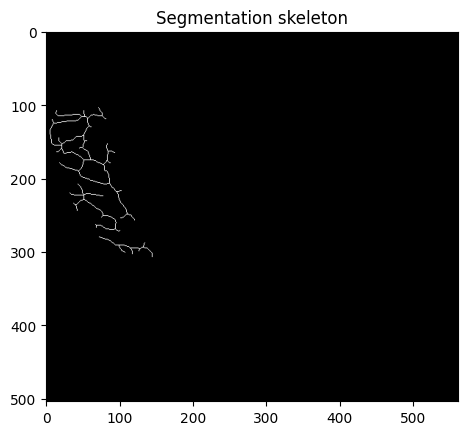

The area is 875.0
There is 32 endpoints and 103 intersection points


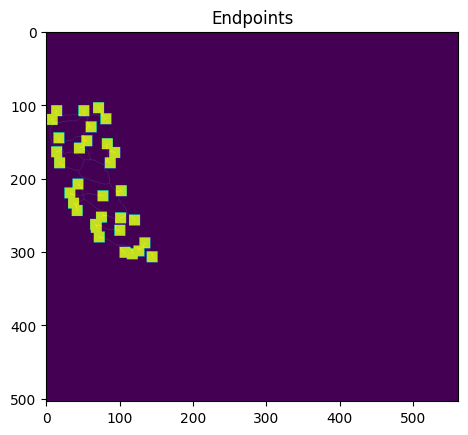

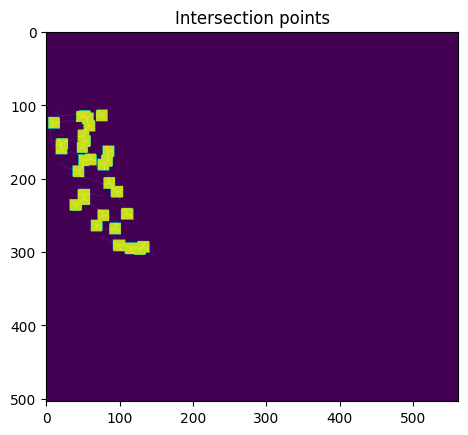

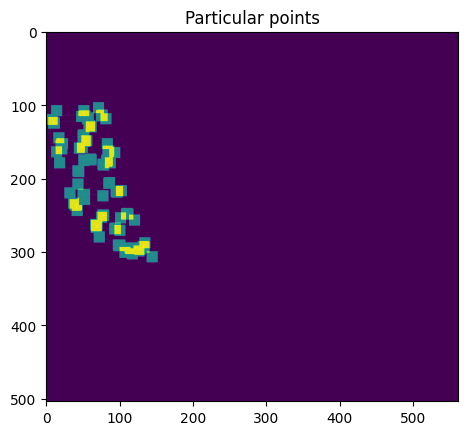

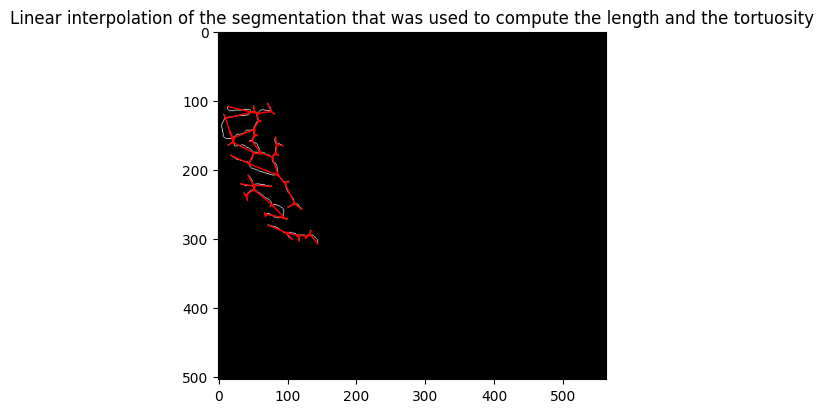

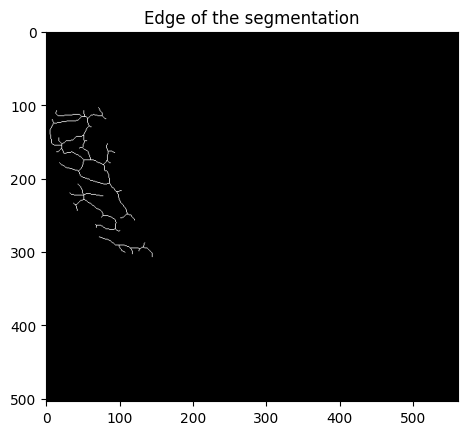

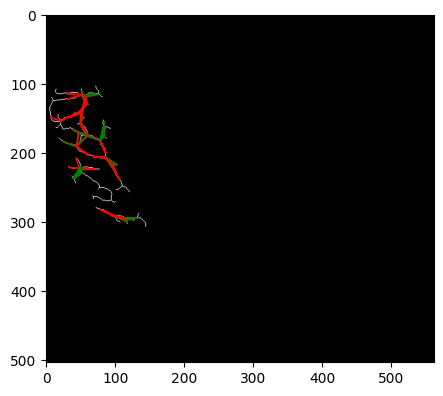

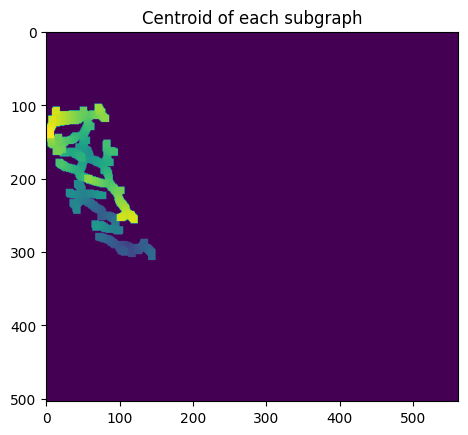

  0%|          | 0/504 [00:00<?, ?it/s]

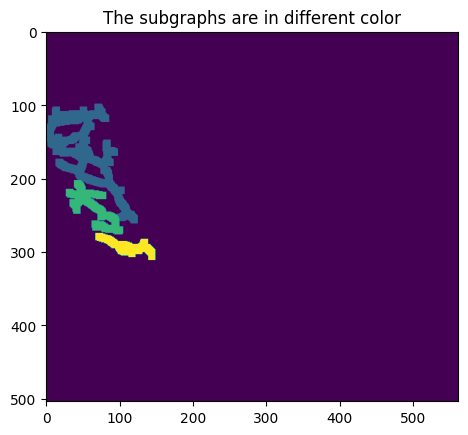

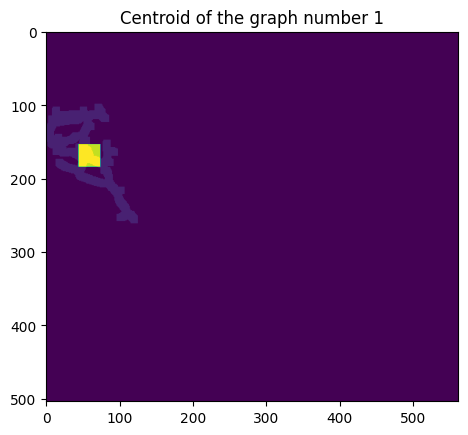

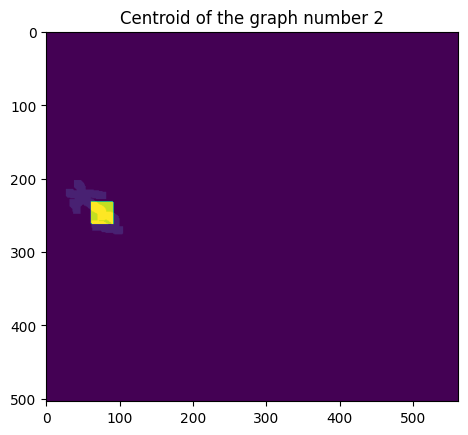

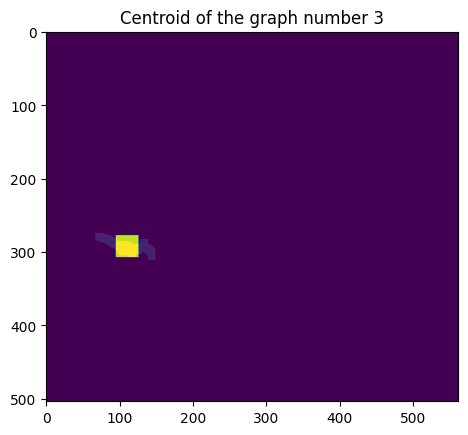

Extracted features: {'area': (296, 127), 'n_endpoints': 32, 'n_intersections': 103, 'median_tortuosity': 1.0821722468774728, 'length': 682.6178582432326, 'perimeter': 1013.7615433949869, 'mean_branching_angle': 85.30224983575465, 'std_branching_angle': 61.63319556194605, 'median_branching_angle': 102.71976412247814, 'D0': 1.287517544388413, 'D1': 1.287517544388413}


In [ ]:
# import os
# import numpy as np
# from PIL import Image
# from skimage.morphology import skeletonize, square, dilation, remove_small_objects, remove_small_holes
# from skimage.filters import threshold_otsu
# from skimage import io
# import matplotlib.pyplot as plt
# from PVBM.GeometricalAnalysis import GeometricalVBMs
# from tqdm.notebook import tqdm
# from queue import PriorityQueue
# import cv2

# # Box-counting method to calculate fractal dimension
# def box_counting_method(image):
#     sizes = np.arange(2, 100, 2)  # customizable
#     counts = []
#     for size in sizes:
#         count = 0
#         # Slide the box across the image
#         for x in range(0, image.shape[1], size):
#             for y in range(0, image.shape[0], size):
#                 roi = image[y:y+size, x:x+size]
#                 if np.any(roi):
#                     count += 1
#         counts.append(count)

#     # Linear fit to estimate the slope (fractal dimension)
#     coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
#     return -coeffs[0]

# # Extract subgraphs
# def iterative(A, B, i, j, n):
#     pq = PriorityQueue()
#     pq.put((0, A, B, i, j, n))
#     priotities = [0, 1, 2, 3, 4, 5, 6, 7]
#     while not pq.empty():
#         _, A, B, i, j, n = pq.get()
#         directions = [(i-1, j), (i+1, j), (i, j-1), (i, j+1), (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
#         for direction, priority in zip(directions, priotities):
#             x, y = direction
#             if 0 <= x < A.shape[0] and 0 <= y < A.shape[1] and A[direction] == 1:
#                 B[direction] = n
#                 A[direction] = 0
#                 pq.put((priority, A, B, direction[0], direction[1], n))

# def extract_subgraphs(graphs):
#     B = np.zeros_like(graphs)
#     n = 1
#     for i in tqdm(range(graphs.shape[0])):
#         for j in range(graphs.shape[1]):
#             if B[i, j] == 0 and graphs[i, j] == 1:
#                 iterative(graphs, B, i, j, n)
#                 n += 1
#     return B

# # Main function to process and extract features
# def extract_features(image_path):
#     segmentation = Image.open(image_path)
#     segmentation = np.array(segmentation) / 255
#     skeleton = segmentation

#     geometricalVBMs = GeometricalVBMs()
#     a = geometricalVBMs.area(segmentation)
#     print("The area is {}".format(a))
#     n_end, n_inter, end, inter = geometricalVBMs.compute_particular_points(skeleton)
#     print("There is {} endpoints and {} intersection points".format(n_end,n_inter))

#     end_dilated = dilation(end, square(15))
#     inter_dilated = dilation(inter, square(15))
#     plt.imshow(segmentation/10+end_dilated)
#     plt.title('Endpoints')
#     plt.show()

#     plt.imshow(segmentation/10+inter_dilated)
#     plt.title("Intersection points")
#     plt.show()

#     plt.imshow(segmentation/10+inter_dilated+end_dilated)
#     plt.title("Particular points")
#     plt.show()

#     median_tor, length, chord, arc, connection_dico = geometricalVBMs.compute_tortuosity_length(skeleton)

#     fig = plt.figure(figsize=(5,5))
#     for key,values in connection_dico.items():
#         x1,y1 = key
#         for value in values:
#             x2,y2 = value[0][0],value[0][1]
#             x_ = (x1,x2)
#             y_ = (y1,y2)
#             plt.plot(y_,x_, color="red", linewidth=1)
#     plt.imshow(segmentation,cmap = 'gray')
#     plt.title('Linear interpolation of the segmentation that was used to compute the length and the tortuosity')
#     plt.show()

#     p, border_matrix = geometricalVBMs.compute_perimeter(segmentation)

#     plt.imshow(border_matrix,cmap = "gray")
#     plt.title("Edge of the segmentation")
#     plt.show()


#     mean_ba, std_ba, median_ba, angle_dico, centroid = geometricalVBMs.compute_branching_angles(skeleton)

#     fig = plt.figure(figsize=(5,5))
#     for points,angle in angle_dico.items():
#         b,a,c = points
#         if True:
#             if angle > 90 :
#                 x_ = [b[0],a[0]]
#                 y_ = [b[1],a[1]]
#                 plt.plot(y_,x_, color="red", linewidth=1)
#                 x_ = [b[0],c[0]]
#                 y_ = [b[1],c[1]]
#                 plt.plot(y_,x_, color="red", linewidth=1)
#             if angle < 90 :
#                 x_ = [b[0],a[0]]
#                 y_ = [b[1],a[1]]
#                 plt.plot(y_,x_, color="green", linewidth=1)
#                 x_ = [b[0],c[0]]
#                 y_ = [b[1],c[1]]
#                 plt.plot(y_,x_, color="green", linewidth=1)
#     plt.imshow(skeleton,cmap = 'gray')
#     plt.show()

#     plt.imshow(dilation(centroid,square(10)))
#     plt.title("Centroid of each subgraph")
#     plt.show()

#     graphs = 1 * (centroid != -1)
#     B = extract_subgraphs(graphs.copy())

#     plt.imshow(dilation(B*100,square(10)))
#     plt.title("The subgraphs are in different color")
#     plt.show()

#     for i in range(1,B.max()+1):
#       mask = B == i
#       sub_skeleton = skeleton * mask
#       sub_centroid = centroid * mask
#       sub_centroid_tmp = sub_centroid.copy()
#       sub_centroid_tmp[sub_centroid_tmp == 0 ] = np.inf
#       detected_centroid = sub_centroid_tmp == sub_centroid_tmp.min()
#       plt.imshow(dilation(sub_skeleton,square(10)) + 10*dilation(detected_centroid,square(30)))
#       plt.title("Centroid of the graph number {}".format(i))
#       plt.show()

#     # Compute fractal dimensions using the box-counting method
#     D0 = box_counting_method(segmentation)
#     D1 = box_counting_method(skeleton)

#     features = {
#         "area": a,
#         "n_endpoints": n_end,
#         "n_intersections": n_inter,
#         "median_tortuosity": median_tor,
#         "length": length,
#         "perimeter": p,
#         "mean_branching_angle": mean_ba,
#         "std_branching_angle": std_ba,
#         "median_branching_angle": median_ba,
#         "D0": D0,
#         "D1": D1
#     }

#     return features

# # Example usage
# image_path = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Skeleton_masks_4_NoBorder/mask_vesselness_Processed_ROI_Paz_23.4.png'
# segmentation= Image.open(image_path)
# segmentation = np.array(segmentation)/255
# skeleton = segmentation
# plt.imshow(skeleton,cmap = 'gray')
# plt.title("Segmentation skeleton")
# plt.show()
# features = extract_features(image_path)
# print("Extracted features:", features)

#Classifier parameter creation:)

code reads patient and feature data, preprocesses it, and merges it to create a single dataset. It then splits the data into training, validation, and test sets. A Random Forest classifier is used, and hyperparameters are tuned using GridSearchCV with a progress bar to show the tuning process. Finally, the best model is evaluated on the validation and test sets, and various evaluation metrics are printed.

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from skimage.morphology import skeletonize, square, dilation, remove_small_objects, remove_small_holes
from skimage.filters import threshold_otsu
from skimage import io
from PVBM.GeometricalAnalysis import GeometricalVBMs
from tqdm.notebook import tqdm
from queue import PriorityQueue
import cv2
from google.colab import files

# Box-counting method to calculate fractal dimension
def box_counting_method(image):
    sizes = np.arange(2, 100, 2)  # customizable
    counts = []
    for size in sizes:
        count = 0
        # Slide the box across the image
        for x in range(0, image.shape[1], size):
            for y in range(0, image.shape[0], size):
                roi = image[y:y+size, x:x+size]
                if np.any(roi):
                    count += 1
        counts.append(count)

    # Linear fit to estimate the slope (fractal dimension)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

# Extract subgraphs
def iterative(A, B, i, j, n):
    pq = PriorityQueue()
    pq.put((0, A, B, i, j, n))
    priotities = [0, 1, 2, 3, 4, 5, 6, 7]
    while not pq.empty():
        _, A, B, i, j, n = pq.get()
        directions = [(i-1, j), (i+1, j), (i, j-1), (i, j+1), (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
        for direction, priority in zip(directions, priotities):
            x, y = direction
            if 0 <= x < A.shape[0] and 0 <= y < A.shape[1] and A[direction] == 1:
                B[direction] = n
                A[direction] = 0
                pq.put((priority, A, B, direction[0], direction[1], n))

def extract_subgraphs(graphs):
    B = np.zeros_like(graphs)
    n = 1
    for i in tqdm(range(graphs.shape[0])):
        for j in range(graphs.shape[1]):
            if B[i, j] == 0 and graphs[i, j] == 1:
                iterative(graphs, B, i, j, n)
                n += 1
    return B

# Main function to process and extract features
def extract_features(image_path):
    segmentation = Image.open(image_path)
    segmentation = np.array(segmentation) / 255
    skeleton = segmentation

    geometricalVBMs = GeometricalVBMs()
    a = geometricalVBMs.area(segmentation)
    n_end, n_inter, end, inter = geometricalVBMs.compute_particular_points(skeleton)
    median_tor, length, chord, arc, connection_dico = geometricalVBMs.compute_tortuosity_length(skeleton)
    p, border_matrix = geometricalVBMs.compute_perimeter(segmentation)
    mean_ba, std_ba, median_ba, angle_dico, centroid = geometricalVBMs.compute_branching_angles(skeleton)

    graphs = 1 * (centroid != -1)
    B = extract_subgraphs(graphs.copy())

    # Compute fractal dimensions using the box-counting method
    D0 = box_counting_method(segmentation)
    D1 = box_counting_method(skeleton)

    features = {
        "area": a,
        "n_endpoints": n_end,
        "n_intersections": n_inter,
        "median_tortuosity": median_tor,
        "length": length,
        "perimeter": p,
        "mean_branching_angle": mean_ba,
        "std_branching_angle": std_ba,
        "median_branching_angle": median_ba,
        "D0": D0,
        "D1": D1
    }

    return features

# Directory containing the images
input_directory = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/Skeleton_masks_4_NoBorder'
output_csv = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/feature_dataset.csv'

# Load existing dataset if it exists
if os.path.exists(output_csv):
    existing_df = pd.read_csv(output_csv)
    existing_filenames = set(existing_df['filename'].tolist())
else:
    existing_df = pd.DataFrame()
    existing_filenames = set()

# Create an empty list to store feature dictionaries
feature_list = []

# Process each image in the directory
for filename in os.listdir(input_directory):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')) and filename not in existing_filenames:
        image_path = os.path.join(input_directory, filename)
        features = extract_features(image_path)
        features['filename'] = filename
        feature_list.append(features)

# Create a DataFrame from the feature list
new_df = pd.DataFrame(feature_list)

# Concatenate with existing DataFrame
final_df = pd.concat([existing_df, new_df], ignore_index=True)
final_df.to_csv(output_csv, index=False)
files.download(output_csv)

print(f"Feature dataset saved and downloaded from {output_csv}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Feature dataset saved and downloaded from /content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/feature_dataset.csv


In [5]:
import pandas as pd
feature_dataset=pd.read_csv('/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/feature_dataset.csv')
print(feature_dataset.head(10))

      area  n_endpoints  n_intersections  median_tortuosity        length  \
0   2794.0           76              233           1.080074   2299.721214   
1   5205.0          106              442           1.082040   4519.587847   
2   2875.0           88              299           1.078992   2366.461272   
3  10707.0          313              772           1.080890   9669.612806   
4   2223.0           82              127           1.075442   2015.966389   
5   1205.0           53              139           1.083840    850.108127   
6  14057.0          357             1053           1.079669  12747.854698   
7    875.0           32              103           1.082172    682.617858   
8   1275.0           41              139           1.076243   1069.509717   
9   1746.0           40              148           1.076243   1600.166780   

      perimeter  mean_branching_angle  std_branching_angle  \
0   3221.468396             93.602865            50.712357   
1   6057.037298             

In [6]:
patient_data=pd.read_excel('/content/Database_Nameless.xlsx')
print(patient_data.head(10))

   Patient number ID IMPEDE study  LOH   Dysplasia grading
0               1     IMP-001-024   NaN                NaN
1               2     IMP-001-030   0.0                1.0
2               3     IMP-001-009   1.0                1.0
3               4     IMP-001-004   1.0                3.0
4               5     IMP-001-040   1.0                1.0
5               6     IMP-001-014   1.0                1.0
6               7     IMP-001-008   1.0                3.0
7               8     IMP-001-046   0.0                1.0
8               9     IMP-001-010   NaN                NaN
9              10     IMP-001-054   0.0                1.0


#Single split

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
import re
import joblib

# Read the patient data from the Excel file
patient_data_path = '/content/Database_Nameless.xlsx'
patients_df = pd.read_excel(patient_data_path)

# Rename the 'LOH ' column to 'LOH' to remove the trailing space
patients_df.rename(columns=lambda x: x.strip(), inplace=True)

# Load the feature dataset
features_df = pd.read_csv('/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/feature_dataset.csv')

# Extract the patient number from the filename
def extract_patient_number(filename):
    match = re.search(r'Paz_?(\d+)', filename)
    return int(match.group(1)) if match else None

# Rename files by removing the prefix 'mask_vesselness_Processed_'
features_df['filename'] = features_df['filename'].str.replace('mask_vesselness_Processed_', '')

# Extract patient number
features_df['Patient number'] = features_df['filename'].apply(extract_patient_number)

# Verify the patient numbers extracted
print("Extracted patient numbers:")
print(sorted(features_df['Patient number'].unique()))

# Print the total number of files analyzed
print("Total number of files analyzed:", len(features_df))

# Merge the datasets on 'Patient number'
merged_df = pd.merge(features_df, patients_df, on='Patient number')

# Drop unwanted columns
merged_df.drop(columns=['Dysplasia grading', 'ID IMPEDE study'], inplace=True)

# Drop rows with missing LOH values and filter patients 1-17 and 20-24
merged_df = merged_df.dropna(subset=['LOH'])
print("Included patient numbers after filtering:", len(merged_df['Patient number'].unique()))

# Select and normalize features and target
X = merged_df[['area', 'n_endpoints', 'n_intersections', 'median_tortuosity', 'length',
               'perimeter', 'mean_branching_angle', 'std_branching_angle',
               'median_branching_angle', 'D0', 'D1']]
y = merged_df['LOH'].astype(int)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Extract patient numbers for grouping AFTER filtering
groups = merged_df['Patient number'].values

# Use LeaveOneGroupOut for cross-validation
logo = LeaveOneGroupOut()
split_data = []

for train_idx, test_idx in logo.split(X_scaled, y, groups):
    test_patient_number = groups[test_idx][0]  # The patient number being used as test in this iteration
    print(f"Testing on patient: {test_patient_number}")

    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]

    # Use .iloc to index based on position in the filtered DataFrame
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Get the filenames for the training and testing sets
    train_filenames = merged_df['filename'].iloc[train_idx].tolist()
    test_filenames = merged_df['filename'].iloc[test_idx].tolist()

    # Save the splits for reuse
    split = {
        'X_train': X_train, 'y_train': y_train,
        'X_test': X_test, 'y_test': y_test,
        'train_idx': train_idx, 'test_idx': test_idx,
        'train_filenames': train_filenames, 'test_filenames': test_filenames, # Add filenames to the split dictionary
        'test_patient_number': test_patient_number  # Add the test patient number for verification
    }
    split_data.append(split)

# Save the split data using joblib
joblib.dump(split_data, 'split_data_loo.pkl')

print(merged_df.head())

print("Leave-One-Out splits created and saved successfully.")

Extracted patient numbers:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Total number of files analyzed: 102
Included patient numbers after filtering: 20
Testing on patient: 2
Testing on patient: 3
Testing on patient: 4
Testing on patient: 5
Testing on patient: 6
Testing on patient: 7
Testing on patient: 8
Testing on patient: 10
Testing on patient: 11
Testing on patient: 12
Testing on patient: 13
Testing on patient: 14
Testing on patient: 15
Testing on patient: 16
Testing on patient: 17
Testing on patient: 20
Testing on patient: 21
Testing on patient: 22
Testing on patient: 23
Testing on patient: 24
     area  n_endpoints  n_intersections  median_tortuosity       length  \
0  2794.0           76              233           1.080074  2299.721214   
1  4071.0           58              291           1.082386  3733.934445   
2  8113.0          215              774           1.081190  6914.074341   
3  4733.0          118              409    

In [8]:
# Create the directory if it doesn't exist
output_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/predictions_output'
os.makedirs(output_dir, exist_ok=True)

In [9]:
first_split = split_data[0]
print("Head of X_train for the first split (features only):")
print(pd.DataFrame(first_split['X_train'], columns=['area', 'n_endpoints', 'n_intersections', 'median_tortuosity', 'length',
                                                    'perimeter', 'mean_branching_angle', 'std_branching_angle',
                                                    'median_branching_angle', 'D0', 'D1']).head())

print("\nHead of y_train for the first split:")
print(first_split['y_train'].head())

print("\nTesting filenames:")
for filename in first_split['test_filenames']:
    print(filename)

print("Leave-One-Out splits created and saved successfully.")

Head of X_train for the first split (features only):
       area  n_endpoints  n_intersections  median_tortuosity    length  \
0 -0.538679    -0.552344        -0.563070          -0.161950 -0.583049   
1 -0.264408    -0.705244        -0.402125           0.540883 -0.228175   
2  0.603726     0.628380         0.938157           0.177121  0.558703   
3 -0.122224    -0.195579        -0.074686           0.283342 -0.091114   
4 -0.029011    -0.042679         0.022436          -0.049462 -0.063779   

   perimeter  mean_branching_angle  std_branching_angle  \
0  -0.541469              0.093815            -0.599082   
1  -0.266832              0.920255            -0.705860   
2   0.609689             -0.090364             0.104924   
3  -0.119671             -0.092232             0.270006   
4  -0.026197              0.004625            -0.317230   

   median_branching_angle        D0        D1  
0                0.450378 -0.686656 -0.686656  
1                1.063788  0.564627  0.564627  
2  

##Random Forest

In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

output_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/predictions_output'
models_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/models'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# Load the split data
split_data = joblib.load('split_data_loo.pkl')

# Initialize lists to store results
accuracies = []
precisions = []
recalls = []
f1_scores = []
conf_matrices = []
all_true_labels = []
all_predicted_labels = []

# Loop through each split and train/evaluate the model
for i, split in enumerate(split_data):
    X_train, y_train = split['X_train'], split['y_train']
    X_test, y_test = split['X_test'], split['y_test']

    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    # Save the trained model
    model_path = os.path.join(models_dir, f'rf_model_split_{i+1}.pkl')
    joblib.dump(rf_model, model_path)
    print(f"Random Forest model saved to {model_path}")

    # Predict on the test set
    y_pred = rf_model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Append metrics to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)
    all_true_labels.extend(y_test)
    all_predicted_labels.extend(y_pred)

    # Print the results for the current split
    print(f"Split {i+1}:")
    print(f"Testing on patient: {split['test_patient_number']}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}\n")
    print(f"True labels: {y_test}")
    print(f"Predicted labels: {y_pred}\n")

# Calculate and print the average performance metrics
print("Average Performance Metrics:")
print(f"Accuracy: {np.mean(accuracies)}")
print(f"Precision: {np.mean(precisions)}")
print(f"Recall: {np.mean(recalls)}")
print(f"F1 Score: {np.mean(f1_scores)}")

# Save the results to a file
results = {
    'accuracies': accuracies,
    'precisions': precisions,
    'recalls': recalls,
    'f1_scores': f1_scores,
    'conf_matrices': conf_matrices,
    'true_labels': all_true_labels,
    'predicted_labels': all_predicted_labels
}

joblib.dump(results, os.path.join(output_dir, 'loo_rf_results.pkl'))

# Save true and predicted labels to CSV for ensemble
df_labels = pd.DataFrame({
    'true_labels': all_true_labels,
    'predicted_labels': all_predicted_labels
})
df_labels.to_csv(os.path.join(output_dir, 'rf_labels.csv'), index=False)

# Save model weights (example)
rf_model_path = os.path.join(models_dir, 'rf_model_fold_{i+1}.pkl')
joblib.dump(rf_model, rf_model_path)

Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_1.pkl
Split 1:
Testing on patient: 2
Accuracy: 0.6666666666666666
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2 1]
 [0 0]]

True labels: 86    0
87    0
88    0
Name: LOH, dtype: int64
Predicted labels: [0 0 1]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_2.pkl
Split 2:
Testing on patient: 3
Accuracy: 0.25
Precision: 1.0
Recall: 0.25
F1 Score: 0.4
Confusion Matrix:
[[0 0]
 [3 1]]

True labels: 58    1
59    1
60    1
61    1
Name: LOH, dtype: int64
Predicted labels: [1 0 0 0]

Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_3.pkl
Split 3:
Testing on patient: 4
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[0 0]
 [4 0]]

True labels: 7     1
8     1
9     1
10    1
Name: LOH, dtype: int64
Predicted labels: [0 0 0 0]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_4.pkl
Split 4:
Testing on patient: 5
Accuracy: 0.4
Precision: 1.0
Recall: 0.4
F1 Score: 0.5714285714285715
Confusion Matrix:
[[0 0]
 [3 2]]

True labels: 40    1
41    1
42    1
43    1
44    1
Name: LOH, dtype: int64
Predicted labels: [0 0 0 1 1]

Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_5.pkl
Split 5:
Testing on patient: 6
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F1 Score: 0.5
Confusion Matrix:
[[0 0]
 [2 1]]

True labels: 55    1
56    1
57    1
Name: LOH, dtype: int64
Predicted labels: [1 0 0]

Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_6.pkl
Split 6:
Testing on patient: 7
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666
Confusion Matrix:
[[0 0]
 [2 2]]

True labels: 29    1
30    1
31    1
32    1
Name: LOH, dtype: int64
Pre

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_8.pkl
Split 8:
Testing on patient: 10
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[5]]

True labels: 91    0
92    0
93    0
94    0
95    0
Name: LOH, dtype: int64
Predicted labels: [0 0 0 0 0]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_9.pkl
Split 9:
Testing on patient: 11
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[0 0]
 [4 0]]

True labels: 73    1
74    1
75    1
76    1
Name: LOH, dtype: int64
Predicted labels: [0 0 0 0]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_10.pkl
Split 10:
Testing on patient: 12
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[7]]

True labels: 20    0
21    0
22    0
23    0
24    0
25    0
26    0
Name: LOH, dtype: int64
Predicted labels: [0 0 0 0 0 0 0]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_11.pkl
Split 11:
Testing on patient: 13
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2 2]
 [0 0]]

True labels: 65    0
66    0
67    0
68    0
Name: LOH, dtype: int64
Predicted labels: [1 1 0 0]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_12.pkl
Split 12:
Testing on patient: 14
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2 3]
 [0 0]]

True labels: 35    0
36    0
37    0
38    0
39    0
Name: LOH, dtype: int64
Predicted labels: [1 0 0 1 1]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_13.pkl
Split 13:
Testing on patient: 15
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[1 1]
 [0 0]]

True labels: 63    0
64    0
Name: LOH, dtype: int64
Predicted labels: [1 0]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_14.pkl
Split 14:
Testing on patient: 16
Accuracy: 0.2857142857142857
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2 5]
 [0 0]]

True labels: 0    0
1    0
2    0
3    0
4    0
5    0
6    0
Name: LOH, dtype: int64
Predicted labels: [0 1 1 1 0 1 1]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_15.pkl
Split 15:
Testing on patient: 17
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[3]]

True labels: 96    0
97    0
98    0
Name: LOH, dtype: int64
Predicted labels: [0 0 0]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_16.pkl
Split 16:
Testing on patient: 20
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[2]]

True labels: 33    1
34    1
Name: LOH, dtype: int64
Predicted labels: [1 1]

Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_17.pkl
Split 17:
Testing on patient: 21
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[0 1]
 [0 0]]

True labels: 62    0
Name: LOH, dtype: int64
Predicted labels: [1]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_18.pkl
Split 18:
Testing on patient: 22
Accuracy: 0.3333333333333333
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[1 2]
 [0 0]]

True labels: 99     0
100    0
101    0
Name: LOH, dtype: int64
Predicted labels: [1 0 1]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_19.pkl
Split 19:
Testing on patient: 23
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F1 Score: 0.5
Confusion Matrix:
[[0 0]
 [6 3]]

True labels: 11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
Name: LOH, dtype: int64
Predicted labels: [0 1 0 1 0 1 0 0 0]

Random Forest model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_split_20.pkl
Split 20:
Testing on patient: 24
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[2]]

True labels: 27    1
28    1
Name: LOH, dtype: int64
Predicted labels: [1 1]

Average Performance Metrics:
Accuracy: 0.5151190476190477
Precision: 0.35
Recall: 0.19083333333333335
F1 Score: 0.2319047619047619


['/content/drive/MyDrive/NBI_OralCancer_Nameless/models/rf_model_fold_{i+1}.pkl']

In [ ]:
# import joblib
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from sklearn.model_selection import GridSearchCV
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm

# # Load the split data
# split_data = joblib.load('split_data.pkl')
# X_train, y_train = split_data['X_train'], split_data['y_train']
# X_val, y_val = split_data['X_val'], split_data['y_val']
# X_test, y_test = split_data['X_test'], split_data['y_test']

# # Perform hyperparameter tuning using GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1', verbose=0)

# # This is because I like to see the progress bar
# with tqdm(total=len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf'])) as pbar:
#     for params in grid_search.param_grid:
#         grid_search.fit(X_train, y_train)
#         pbar.update(1)

# best_clf = grid_search.best_estimator_
# joblib.dump(best_clf, 'rf_model.pkl')

# best_clf=joblib.load('rf_model.pkl')

# # Validate the model
# y_val_pred = best_clf.predict(X_val)

# # Evaluate the model on the validation set
# val_accuracy = accuracy_score(y_val, y_val_pred)
# val_precision = precision_score(y_val, y_val_pred)
# val_recall = recall_score(y_val, y_val_pred)
# val_f1 = f1_score(y_val, y_val_pred)

# print(f'Validation Accuracy: {val_accuracy:.2f}')
# print(f'Validation Precision: {val_precision:.2f}')
# print(f'Validation Recall: {val_recall:.2f}')
# print(f'Validation F1 Score: {val_f1:.2f}')

# # Test the model on test set
# y_test_pred = best_clf.predict(X_test)
# y_test_proba_rf = best_clf.predict_proba(X_test)[:, 1]  # Probabilities for ensembling
# test_accuracy = accuracy_score(y_test, y_test_pred)
# test_precision = precision_score(y_test, y_test_pred)
# test_recall = recall_score(y_test, y_test_pred)
# test_f1 = f1_score(y_test, y_test_pred)

# print(f'Test Accuracy: {test_accuracy:.2f}')
# print(f'Test Precision: {test_precision:.2f}')
# print(f'Test Recall: {test_recall:.2f}')
# print(f'Test F1 Score: {test_f1:.2f}')

# # Print the filename, true value, and predicted value for each test sample
# test_filenames = merged_df.loc[split_data['test_idx'], 'filename']
# for filename, true_value, predicted_value in zip(test_filenames, y_test, y_test_pred):
#     print(f'Filename: {filename}, True Value: {true_value}, Predicted Value: {predicted_value}')

# # Plot confusion matrix
# conf_matrix = confusion_matrix(y_test, y_test_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['LOH 0', 'LOH 1'], yticklabels=['LOH 0', 'LOH 1'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # Save predictions for ensembling
# rf_test_predictions = pd.DataFrame({
#     'filename': test_filenames,
#     'y_test_proba_rf': y_test_proba_rf,
#     'y_test_true': y_test
# })

# # Save the predictions to the specified directory
# output_filename = os.path.join(output_dir, f'rf_test_predictions_{random_state}.csv')
# rf_test_predictions.to_csv(output_filename, index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split 1:
Testing on patient: 2
Accuracy: 0.6666666666666666
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2 1]
 [0 0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split 2:
Testing on patient: 3
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[0 0]
 [4 0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split 3:
Testing on patient: 4
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[0 0]
 [4 0]]

Split 4:
Testing on patient: 5
Accuracy: 0.2
Precision: 1.0
Recall: 0.2
F1 Score: 0.33333333333333337
Confusion Matrix:
[[0 0]
 [4 1]]

Split 5:
Testing on patient: 6
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F1 Score: 0.5
Confusion Matrix:
[[0 0]
 [2 1]]

Split 6:
Testing on patient: 7
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666
Confusion Matrix:
[[0 0]
 [2 2]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split 7:
Testing on patient: 8
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2 3]
 [0 0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split 8:
Testing on patient: 10
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2 3]
 [0 0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split 9:
Testing on patient: 11
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[0 0]
 [4 0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Split 10:
Testing on patient: 12
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[7]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split 11:
Testing on patient: 13
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2 2]
 [0 0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split 12:
Testing on patient: 14
Accuracy: 0.2
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[1 4]
 [0 0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split 13:
Testing on patient: 15
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[1 1]
 [0 0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split 14:
Testing on patient: 16
Accuracy: 0.42857142857142855
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[3 4]
 [0 0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Split 15:
Testing on patient: 17
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[3]]

Split 16:
Testing on patient: 20
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[2]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split 17:
Testing on patient: 21
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[0 1]
 [0 0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split 18:
Testing on patient: 22
Accuracy: 0.3333333333333333
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[1 2]
 [0 0]]

Split 19:
Testing on patient: 23
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F1 Score: 0.5
Confusion Matrix:
[[0 0]
 [6 3]]

Split 20:
Testing on patient: 24
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[2]]

Average Performance Metrics:
Accuracy: 0.4397619047619047
Precision: 0.3
Recall: 0.16833333333333333
F1 Score: 0.2
Random Forest LOOCV results saved successfully.


## XG Boost

In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

output_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/predictions_output'
models_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/models'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# Load the split data
split_data = joblib.load('split_data_loo.pkl')

# Initialize lists to store results
accuracies = []
precisions = []
recalls = []
f1_scores = []
conf_matrices = []
all_true_labels = []
all_predicted_labels = []

# Loop through each split and train/evaluate the model
for i, split in enumerate(split_data):
    X_train, y_train = split['X_train'], split['y_train']
    X_test, y_test = split['X_test'], split['y_test']

    # Initialize and train the XGBoost model
    xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)

    # Save the trained model
    model_path = os.path.join(models_dir, f'xgb_model_split_{i+1}.pkl')
    joblib.dump(xgb_model, model_path)
    print(f"XGBoost model saved to {model_path}")

    # Predict on the test set
    y_pred = xgb_model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Append metrics to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)
    all_true_labels.extend(y_test)
    all_predicted_labels.extend(y_pred)

    # Print the results for the current split
    print(f"Split {i+1}:")
    print(f"Testing on patient: {split['test_patient_number']}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}\n")
    print(f"True labels: {y_test}")
    print(f"Predicted labels: {y_pred}\n")

# Calculate and print the average performance metrics
print("Average Performance Metrics:")
print(f"Accuracy: {np.mean(accuracies)}")
print(f"Precision: {np.mean(precisions)}")
print(f"Recall: {np.mean(recalls)}")
print(f"F1 Score: {np.mean(f1_scores)}")

# Save the results to a file
results = {
    'accuracies': accuracies,
    'precisions': precisions,
    'recalls': recalls,
    'f1_scores': f1_scores,
    'conf_matrices': conf_matrices,
    'true_labels': all_true_labels,
    'predicted_labels': all_predicted_labels
}

joblib.dump(results, os.path.join(output_dir, 'loo_xgb_results.pkl'))

# Save true and predicted labels to CSV for ensemble
df_labels = pd.DataFrame({
    'true_labels': all_true_labels,
    'predicted_labels': all_predicted_labels
})
df_labels.to_csv(os.path.join(output_dir, 'xgb_labels.csv'), index=False)

# Save model weights (example)
xgb_model_path = os.path.join(models_dir, 'xgb_model_fold_{i+1}.pkl')
joblib.dump(xgb_model, xgb_model_path)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:48:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:48:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/u

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_1.pkl
Split 1:
Testing on patient: 2
Accuracy: 0.6666666666666666
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2 1]
 [0 0]]

True labels: 86    0
87    0
88    0
Name: LOH, dtype: int64
Predicted labels: [0 0 1]

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_2.pkl
Split 2:
Testing on patient: 3
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[0 0]
 [4 0]]

True labels: 58    1
59    1
60    1
61    1
Name: LOH, dtype: int64
Predicted labels: [0 0 0 0]

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_3.pkl
Split 3:
Testing on patient: 4
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666
Confusion Matrix:
[[0 0]
 [2 2]]

True labels: 7     1
8     1
9     1
10    1
Name: LOH, dtype: int64
Predicted labels: [0 1 0 1]



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_4.pkl
Split 4:
Testing on patient: 5
Accuracy: 0.2
Precision: 1.0
Recall: 0.2
F1 Score: 0.33333333333333337
Confusion Matrix:
[[0 0]
 [4 1]]

True labels: 40    1
41    1
42    1
43    1
44    1
Name: LOH, dtype: int64
Predicted labels: [0 0 0 1 0]

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_5.pkl
Split 5:
Testing on patient: 6
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F1 Score: 0.5
Confusion Matrix:
[[0 0]
 [2 1]]

True labels: 55    1
56    1
57    1
Name: LOH, dtype: int64
Predicted labels: [1 0 0]

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_6.pkl
Split 6:
Testing on patient: 7
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F1 Score: 0.8571428571428571
Confusion Matrix:
[[0 0]
 [1 3]]

True labels: 29    1
30    1
31    1
32    1
Name: LOH, dtype: int64
Predicted label

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_7.pkl
Split 7:
Testing on patient: 8
Accuracy: 0.2
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[1 4]
 [0 0]]

True labels: 77    0
78    0
79    0
80    0
81    0
Name: LOH, dtype: int64
Predicted labels: [0 1 1 1 1]

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_8.pkl
Split 8:
Testing on patient: 10
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2 3]
 [0 0]]

True labels: 91    0
92    0
93    0
94    0
95    0
Name: LOH, dtype: int64
Predicted labels: [1 0 0 1 1]

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_9.pkl
Split 9:
Testing on patient: 11
Accuracy: 0.25
Precision: 1.0
Recall: 0.25
F1 Score: 0.4
Confusion Matrix:
[[0 0]
 [3 1]]

True labels: 73    1
74    1
75    1
76    1
Name: LOH, dtype: int64
Predicted labels: [1 0 0 0]



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_10.pkl
Split 10:
Testing on patient: 12
Accuracy: 0.8571428571428571
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[6 1]
 [0 0]]

True labels: 20    0
21    0
22    0
23    0
24    0
25    0
26    0
Name: LOH, dtype: int64
Predicted labels: [0 0 1 0 0 0 0]

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_11.pkl
Split 11:
Testing on patient: 13
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2 2]
 [0 0]]

True labels: 65    0
66    0
67    0
68    0
Name: LOH, dtype: int64
Predicted labels: [1 1 0 0]

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_12.pkl
Split 12:
Testing on patient: 14
Accuracy: 0.2
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[1 4]
 [0 0]]

True labels: 35    0
36    0
37    0
38    0
39    0
Name: LOH, dtype: int64
Predicted labels

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_13.pkl
Split 13:
Testing on patient: 15
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[1 1]
 [0 0]]

True labels: 63    0
64    0
Name: LOH, dtype: int64
Predicted labels: [1 0]

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_14.pkl
Split 14:
Testing on patient: 16
Accuracy: 0.2857142857142857
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2 5]
 [0 0]]

True labels: 0    0
1    0
2    0
3    0
4    0
5    0
6    0
Name: LOH, dtype: int64
Predicted labels: [0 1 0 1 1 1 1]

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_15.pkl
Split 15:
Testing on patient: 17
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[3]]

True labels: 96    0
97    0
98    0
Name: LOH, dtype: int64
Predicted labels: [0 0 0]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:48:36] WARNING: /workspace/src/le

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_16.pkl
Split 16:
Testing on patient: 20
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666
Confusion Matrix:
[[0 0]
 [1 1]]

True labels: 33    1
34    1
Name: LOH, dtype: int64
Predicted labels: [0 1]

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_17.pkl
Split 17:
Testing on patient: 21
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[0 1]
 [0 0]]

True labels: 62    0
Name: LOH, dtype: int64
Predicted labels: [1]

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_split_18.pkl
Split 18:
Testing on patient: 22
Accuracy: 0.3333333333333333
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[1 2]
 [0 0]]

True labels: 99     0
100    0
101    0
Name: LOH, dtype: int64
Predicted labels: [1 0 1]

XGBoost model saved to /content/drive/MyDrive/NBI_OralCancer_Namele

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:48:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['/content/drive/MyDrive/NBI_OralCancer_Nameless/models/xgb_model_fold_{i+1}.pkl']

  2%|▏         | 5/243 [05:54<4:40:51, 70.81s/it]


Validation Accuracy: 0.58
Validation Precision: 0.50
Validation Recall: 0.60
Validation F1 Score: 0.55
Test Accuracy: 0.62
Test Precision: 0.57
Test Recall: 0.67
Test F1 Score: 0.62
Filename: mask_vesselness_Processed_ROI_Paz10.2.png, True Value: 0, Predicted Value: 1
Filename: mask_vesselness_Processed_ROI_Paz_24.2.png, True Value: 1, Predicted Value: 1
Filename: mask_vesselness_Processed_ROI_Paz_24.1.png, True Value: 1, Predicted Value: 0
Filename: mask_vesselness_Processed_ROI_Paz12.3.png, True Value: 0, Predicted Value: 0
Filename: mask_vesselness_Processed_ROI_Paz10.1.png, True Value: 0, Predicted Value: 0
Filename: mask_vesselness_Processed_ROI_Paz4.1.png, True Value: 1, Predicted Value: 1
Filename: mask_vesselness_Processed_ROI_Paz12.7.png, True Value: 0, Predicted Value: 0
Filename: mask_vesselness_Processed_ROI_Paz5.3.png, True Value: 1, Predicted Value: 1
Filename: mask_vesselness_Processed_ROI_Paz15.1.png, True Value: 0, Predicted Value: 0
Filename: mask_vesselness_Processed

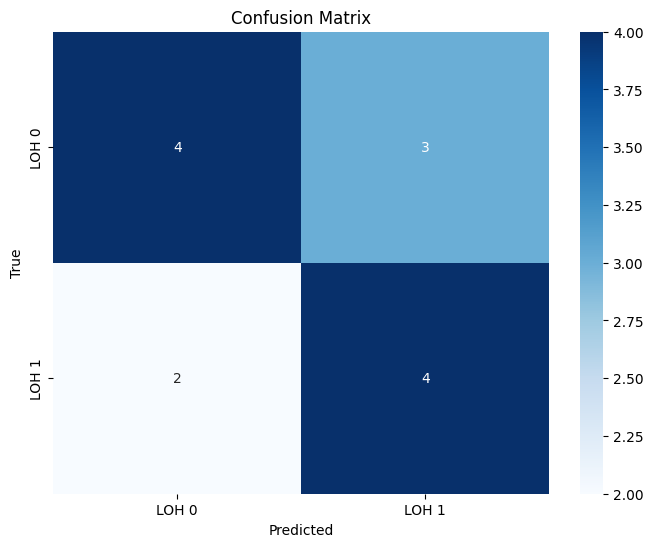

In [ ]:
# import joblib
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# import xgboost as xgb
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm

# # Load the split data
# split_data = joblib.load('split_data.pkl')
# X_train, y_train = split_data['X_train'], split_data['y_train']
# X_val, y_val = split_data['X_val'], split_data['y_val']
# X_test, y_test = split_data['X_test'], split_data['y_test']

# # Define the model
# xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# # Perform hyperparameter tuning using GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9]
# }
# grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1', verbose=0)

# # Using tqdm with GridSearchCV
# with tqdm(total=len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['subsample']) * len(param_grid['colsample_bytree'])) as pbar:
#     for params in grid_search.param_grid:
#         grid_search.fit(X_train, y_train)
#         pbar.update(1)

# best_clf = grid_search.best_estimator_
# joblib.dump(best_clf, 'xgb_model.pkl')

# # Validate the model
# y_val_pred = best_clf.predict(X_val)

# # Evaluate the model on the validation set
# val_accuracy = accuracy_score(y_val, y_val_pred)
# val_precision = precision_score(y_val, y_val_pred, zero_division=0)
# val_recall = recall_score(y_val, y_val_pred, zero_division=0)
# val_f1 = f1_score(y_val, y_val_pred, zero_division=0)

# print(f'Validation Accuracy: {val_accuracy:.2f}')
# print(f'Validation Precision: {val_precision:.2f}')
# print(f'Validation Recall: {val_recall:.2f}')
# print(f'Validation F1 Score: {val_f1:.2f}')

# # Test the model
# y_test_pred = best_clf.predict(X_test)
# y_test_proba_xgb = best_clf.predict_proba(X_test)[:, 1]  # Probabilities for ensembling

# # Evaluate the model on the test set
# test_accuracy = accuracy_score(y_test, y_test_pred)
# test_precision = precision_score(y_test, y_test_pred, zero_division=0)
# test_recall = recall_score(y_test, y_test_pred, zero_division=0)
# test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

# print(f'Test Accuracy: {test_accuracy:.2f}')
# print(f'Test Precision: {test_precision:.2f}')
# print(f'Test Recall: {test_recall:.2f}')
# print(f'Test F1 Score: {test_f1:.2f}')

# # Print the filename, true value, and predicted value for each test sample
# test_filenames = merged_df.loc[split_data['test_idx'], 'filename']
# for filename, true_value, predicted_value in zip(test_filenames, y_test, y_test_pred):
#     print(f'Filename: {filename}, True Value: {true_value}, Predicted Value: {predicted_value}')

# # Plot confusion matrix
# conf_matrix = confusion_matrix(y_test, y_test_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['LOH 0', 'LOH 1'], yticklabels=['LOH 0', 'LOH 1'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # Save predictions for ensembling
# xgb_test_predictions = pd.DataFrame({
#     'filename': test_filenames,
#     'y_test_proba_xgb': y_test_proba_xgb,
#     'y_test_true': y_test
# })

# # Save the predictions to the specified directory
# output_filename = os.path.join(output_dir, f'xgb_test_predictions_{random_state}.csv')
# rf_test_predictions.to_csv(output_filename, index=False)

## CNN

In [12]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [13]:
print(merged_df.head())

     area  n_endpoints  n_intersections  median_tortuosity       length  \
0  2794.0           76              233           1.080074  2299.721214   
1  4071.0           58              291           1.082386  3733.934445   
2  8113.0          215              774           1.081190  6914.074341   
3  4733.0          118              409           1.081539  4287.860468   
4  5167.0          136              444           1.080444  4398.333844   

     perimeter  mean_branching_angle  std_branching_angle  \
0  3221.468396             93.602865            50.712357   
1  4703.504110            100.577890            50.404048   
2  9433.512837             92.048424            52.745103   
3  5497.638236             92.032652            53.221760   
4  6002.054542             92.850115            51.526178   

   median_branching_angle        D0        D1         filename  \
0              104.910314  1.272889  1.272889  ROI_Paz16.3.png   
1              111.983631  1.372273  1.372273  ROI

In [ ]:
# import os
# import pandas as pd
# import numpy as np
# from keras.preprocessing.image import load_img, img_to_array
# from sklearn.preprocessing import StandardScaler
# from keras.models import Model
# from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate
# from tqdm import tqdm
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# import joblib

# # Define the path to your image directory
# image_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/'

# # Define the path to save the models
# model_save_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/models'
# os.makedirs(model_save_dir, exist_ok=True)

# # Define the path to save the predictions
# output_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/predictions_output'
# os.makedirs(output_dir, exist_ok=True)

# # Load images
# def load_image(filename):
#     img_path = os.path.join(image_dir, filename)
#     if not os.path.exists(img_path):
#         print(f"File {img_path} does not exist!")
#         return np.zeros((64, 64, 3))  # Return an array of zeros if file doesn't exist
#     img = load_img(img_path, target_size=(64, 64))  # Resize if needed
#     img_array = img_to_array(img)
#     img_array = img_array / 255.0  # Normalize the images
#     return img_array

# # Assuming merged_df is already loaded and available with correct filenames
# merged_df['image'] = merged_df['filename'].apply(load_image)

# # Extract features and labels
# X_tabular = merged_df.drop(columns=['filename', 'image', 'LOH']).values
# X_images = np.array(list(merged_df['image']))
# y = merged_df['LOH'].values

# # Standardize the tabular data
# scaler = StandardScaler()
# X_tabular = scaler.fit_transform(X_tabular)

# def create_combined_model(input_shape_image, input_shape_tabular):
#     # CNN for image data
#     image_input = Input(shape=input_shape_image)
#     x = Conv2D(32, (3, 3), activation='relu')(image_input)
#     x = MaxPooling2D((2, 2))(x)
#     x = Flatten()(x)

#     # Dense network for tabular data
#     tabular_input = Input(shape=(input_shape_tabular,))
#     y = Dense(64, activation='relu')(tabular_input)

#     # Combine the outputs
#     combined = concatenate([x, y])

# #add layer normalization ###

#     z = Dense(64, activation='relu')(combined)
#     z = Dense(1, activation='sigmoid')(z)  # Assuming binary classification

#     model = Model(inputs=[image_input, tabular_input], outputs=z)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# input_shape_image = (64, 64, 3)
# input_shape_tabular = X_tabular.shape[1]

# # Load the split data
# split_data = joblib.load('split_data_loo.pkl')

# # Initialize lists to collect true labels and predictions
# true_labels = []
# predicted_labels = []

# # Use tqdm to add a progress bar
# with tqdm(total=len(split_data), desc="LOOCV Progress") as pbar:
#     for i, split in enumerate(split_data):
#         X_train, y_train = split['X_train'], split['y_train']
#         X_test, y_test = split['X_test'], split['y_test']

#         # Get the indices for the current split
#         train_indices = split['train_idx']
#         test_indices = split['test_idx']

#         # Prepare the image and tabular data for the current split
#         X_train_images = np.array([X_images[j] for j in train_indices])
#         X_test_images = np.array([X_images[j] for j in test_indices])
#         X_train_tabular = np.array([X_tabular[j] for j in train_indices])
#         X_test_tabular = np.array([X_tabular[j] for j in test_indices])

#         model = create_combined_model(input_shape_image, input_shape_tabular)
#         model.fit([X_train_images, X_train_tabular], y_train, epochs=10, batch_size=32, verbose=0)

#         # Save the model weights
#         model.save_weights(os.path.join(model_save_dir, f'cnn_model_split_{i + 1}.h5'))

#         predictions = model.predict([X_test_images, X_test_tabular])
#         predicted_label = np.round(predictions).flatten()

#         true_labels.append(y_test.iloc[0])
#         predicted_labels.append(predicted_label[0])

#         # Print the confusion matrix and true/predicted labels for the current split
#         conf_matrix = confusion_matrix([y_test.iloc[0]], [predicted_label[0]])
#         print(f"Split {i+1}:")
#         print(f"Testing on patient: {split['test_patient_number']}")
#         print(f"Confusion Matrix:\n{conf_matrix}\n")
#         print(f"True label: {y_test.iloc[0]}")
#         print(f"Predicted label: {predicted_label[0]}\n")

#         # Update the progress bar
#         pbar.update(1)

# # Convert to numpy arrays for metric computation
# true_labels = np.array(true_labels)
# predicted_labels = np.array(predicted_labels)

# # Compute evaluation metrics
# accuracy = accuracy_score(true_labels, predicted_labels)
# precision = precision_score(true_labels, predicted_labels)
# recall = recall_score(true_labels, predicted_labels)
# f1 = f1_score(true_labels, predicted_labels)

# print(f'Accuracy: {accuracy:.4f}')
# print(f'Precision: {precision:.4f}')
# print(f'Recall: {recall:.4f}')
# print(f'F1 Score: {f1:.4f}')

# # Save results using joblib
# results = {
#     'true_labels': true_labels,
#     'predicted_labels': predicted_labels,
#     'accuracy': accuracy,
#     'precision': precision,
#     'recall': recall,
#     'f1_score': f1
# }
# joblib.dump(results, os.path.join(output_dir, 'loo_cnn_tabular_results.pkl'))

# # Save true and predicted labels to CSV for ensemble
# df_labels = pd.DataFrame({
#     'true_labels': true_labels,
#     'predicted_labels': predicted_labels
# })
# df_labels.to_csv(os.path.join(output_dir, 'cnn_labels.csv'), index=False)

# print("CNN with Tabular Data LOOCV results and labels saved successfully.")

LOOCV Progress:   0%|          | 0/20 [00:00<?, ?it/s]

1/1 [==============================] - 0s 132ms/step


LOOCV Progress:   5%|▌         | 1/20 [00:06<02:07,  6.74s/it]

Split 1:
Testing on patient: 2
Confusion Matrix:
[[1]]

True label: 0
Predicted label: 0.0

1/1 [==============================] - 0s 136ms/step


LOOCV Progress:  10%|█         | 2/20 [00:13<01:58,  6.57s/it]

Split 2:
Testing on patient: 3
Confusion Matrix:
[[1]]

True label: 1
Predicted label: 1.0

1/1 [==============================] - 0s 77ms/step


LOOCV Progress:  15%|█▌        | 3/20 [00:18<01:41,  6.00s/it]

Split 3:
Testing on patient: 4
Confusion Matrix:
[[0 0]
 [1 0]]

True label: 1
Predicted label: 0.0

1/1 [==============================] - 0s 86ms/step


LOOCV Progress:  20%|██        | 4/20 [00:22<01:24,  5.30s/it]

Split 4:
Testing on patient: 5
Confusion Matrix:
[[1]]

True label: 1
Predicted label: 1.0

1/1 [==============================] - 0s 107ms/step


LOOCV Progress:  25%|██▌       | 5/20 [00:27<01:17,  5.19s/it]

Split 5:
Testing on patient: 6
Confusion Matrix:
[[1]]

True label: 1
Predicted label: 1.0

1/1 [==============================] - 0s 79ms/step


LOOCV Progress:  30%|███       | 6/20 [00:32<01:10,  5.03s/it]

Split 6:
Testing on patient: 7
Confusion Matrix:
[[0 0]
 [1 0]]

True label: 1
Predicted label: 0.0

1/1 [==============================] - 0s 82ms/step


LOOCV Progress:  35%|███▌      | 7/20 [00:37<01:04,  4.94s/it]

Split 7:
Testing on patient: 8
Confusion Matrix:
[[0 1]
 [0 0]]

True label: 0
Predicted label: 1.0

1/1 [==============================] - 0s 125ms/step


LOOCV Progress:  40%|████      | 8/20 [00:42<01:00,  5.00s/it]

Split 8:
Testing on patient: 10
Confusion Matrix:
[[1]]

True label: 0
Predicted label: 0.0

1/1 [==============================] - 0s 87ms/step


LOOCV Progress:  45%|████▌     | 9/20 [00:47<00:56,  5.11s/it]

Split 9:
Testing on patient: 11
Confusion Matrix:
[[0 0]
 [1 0]]

True label: 1
Predicted label: 0.0

1/1 [==============================] - 0s 86ms/step


LOOCV Progress:  50%|█████     | 10/20 [00:52<00:49,  5.00s/it]

Split 10:
Testing on patient: 12
Confusion Matrix:
[[0 1]
 [0 0]]

True label: 0
Predicted label: 1.0

1/1 [==============================] - 0s 96ms/step


LOOCV Progress:  55%|█████▌    | 11/20 [00:58<00:49,  5.47s/it]

Split 11:
Testing on patient: 13
Confusion Matrix:
[[1]]

True label: 0
Predicted label: 0.0

1/1 [==============================] - 0s 89ms/step


LOOCV Progress:  60%|██████    | 12/20 [01:03<00:42,  5.28s/it]

Split 12:
Testing on patient: 14
Confusion Matrix:
[[1]]

True label: 0
Predicted label: 0.0

1/1 [==============================] - 0s 97ms/step


LOOCV Progress:  65%|██████▌   | 13/20 [01:08<00:35,  5.04s/it]

Split 13:
Testing on patient: 15
Confusion Matrix:
[[0 1]
 [0 0]]

True label: 0
Predicted label: 1.0

1/1 [==============================] - 0s 91ms/step


LOOCV Progress:  70%|███████   | 14/20 [01:16<00:35,  5.94s/it]

Split 14:
Testing on patient: 16
Confusion Matrix:
[[0 1]
 [0 0]]

True label: 0
Predicted label: 1.0

1/1 [==============================] - 0s 79ms/step


LOOCV Progress:  75%|███████▌  | 15/20 [01:20<00:26,  5.40s/it]

Split 15:
Testing on patient: 17
Confusion Matrix:
[[0 1]
 [0 0]]

True label: 0
Predicted label: 1.0

1/1 [==============================] - 0s 108ms/step


LOOCV Progress:  80%|████████  | 16/20 [01:25<00:20,  5.24s/it]

Split 16:
Testing on patient: 20
Confusion Matrix:
[[0 0]
 [1 0]]

True label: 1
Predicted label: 0.0

1/1 [==============================] - 0s 87ms/step


LOOCV Progress:  85%|████████▌ | 17/20 [01:30<00:15,  5.25s/it]

Split 17:
Testing on patient: 21
Confusion Matrix:
[[0 1]
 [0 0]]

True label: 0
Predicted label: 1.0

1/1 [==============================] - 0s 85ms/step


LOOCV Progress:  90%|█████████ | 18/20 [01:35<00:10,  5.08s/it]

Split 18:
Testing on patient: 22
Confusion Matrix:
[[1]]

True label: 0
Predicted label: 0.0

1/1 [==============================] - 0s 129ms/step


LOOCV Progress:  95%|█████████▌| 19/20 [01:40<00:05,  5.00s/it]

Split 19:
Testing on patient: 23
Confusion Matrix:
[[0 0]
 [1 0]]

True label: 1
Predicted label: 0.0

1/1 [==============================] - 0s 79ms/step


LOOCV Progress: 100%|██████████| 20/20 [01:44<00:00,  5.25s/it]

Split 20:
Testing on patient: 24
Confusion Matrix:
[[0 0]
 [1 0]]

True label: 1
Predicted label: 0.0

Accuracy: 0.4000
Precision: 0.3333
Recall: 0.3333
F1 Score: 0.3333
CNN with Tabular Data LOOCV results and labels saved successfully.


In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm
import joblib
from torchvision import transforms
from PIL import Image

# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, tabular_data, images, labels, transform=None):
        self.tabular_data = tabular_data
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        tabular_data = self.tabular_data[idx]
        label = self.labels[idx]
        return tabular_data, image, label

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.ln1 = nn.LayerNorm([32, 64, 64])  # Adapt size to output feature map
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.ln2 = nn.LayerNorm([64, 32, 32])  # Adapt size to output feature map
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.ln3 = nn.LayerNorm([128, 16, 16])  # Adapt size to output feature map
        self.fc1 = nn.Linear(128 * 8 * 8, 128)  # Ensure size matches
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.ln1(x)  # Apply LayerNorm after convolution
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.ln2(x)  # Apply LayerNorm after convolution
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.ln3(x)  # Apply LayerNorm after convolution
        x = self.pool(x)
        x = x.view(-1, 128 * 8 * 8)  # Flatten before fully connected layer
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return x

# Define Tabular model
class TabularNN(nn.Module):
    def __init__(self, input_dim):
        super(TabularNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x

# Define Combined model
class CombinedModel(nn.Module):
    def __init__(self, cnn, tabular_nn):
        super(CombinedModel, self).__init__()
        self.cnn = cnn
        self.tabular_nn = tabular_nn
        self.fc1 = nn.Linear(128 + 32, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, image, tabular):
        cnn_out = self.cnn(image)
        tabular_out = self.tabular_nn(tabular)
        combined = torch.cat((cnn_out, tabular_out), dim=1)
        x = self.relu(self.fc1(combined))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Define the path to your image directory
image_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/ROIs/'
output_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/predictions_output'
models_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/models'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# Load images
def load_image(filename):
    img_path = os.path.join(image_dir, filename)
    if not os.path.exists(img_path):
        print(f"File {img_path} does not exist!")
        return np.zeros((64, 64, 3))  # Return an array of zeros if file doesn't exist
    img = Image.open(img_path).convert('RGB').resize((64, 64))  # Ensure image is RGB
    img_array = np.array(img) / 255.0  # Normalize the images
    return img_array

# Assuming merged_df is already loaded and available with correct filenames
merged_df['image'] = merged_df['filename'].apply(load_image)

# Extract features and labels
X_tabular = merged_df.drop(columns=['filename', 'image', 'LOH']).values
X_images = np.array(list(merged_df['image']))
y = merged_df['LOH'].values

# Standardize the tabular data
scaler = StandardScaler()
X_tabular = scaler.fit_transform(X_tabular)

# Convert to torch tensors
X_tabular = torch.tensor(X_tabular, dtype=torch.float32)
X_images = np.stack([np.transpose(image, (2, 0, 1)) for image in X_images])
X_images = torch.tensor(X_images, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Define transformations
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Prepare for LOOCV
loo = LeaveOneOut()
true_labels = []
predicted_labels = []
split_indices = []

# Use tqdm to add a progress bar
with tqdm(total=len(X_images), desc="LOOCV Progress") as pbar:
    for train_index, test_index in loo.split(X_images):
        # Reinitialize the models
        cnn = CNN()
        tabular_nn = TabularNN(X_tabular.shape[1])
        model = CombinedModel(cnn, tabular_nn)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added L2 regularization

        X_train_tabular, X_test_tabular = X_tabular[train_index], X_tabular[test_index]
        X_train_images, X_test_images = X_images[train_index], X_images[test_index]
        y_train, y_test = y[train_index], y[test_index]

        train_dataset = CustomDataset(X_train_tabular, X_train_images, y_train, transform=train_transform)
        test_dataset = CustomDataset(X_test_tabular, X_test_images, y_test)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        # Train the model
        model.train()
        for epoch in range(50):
            total_correct = 0
            total_samples = 0  # Initialize total_samples
            for tabular_batch, image_batch, label_batch in train_loader:
                optimizer.zero_grad()
                output = model(image_batch, tabular_batch)
                loss = criterion(output, label_batch.unsqueeze(1))
                loss.backward()
                optimizer.step()
                pred = torch.round(output)
                correct = (pred == label_batch.unsqueeze(1)).sum().item()
                total = label_batch.size(0)
                total_correct += correct
                total_samples += total
            accuracy = total_correct / total_samples
            #print(f"Epoch {epoch+1}/{40}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            for tabular_batch, image_batch, label_batch in test_loader:
                output = model(image_batch, tabular_batch)
                predicted_label = torch.round(output).item()
                true_labels.append(label_batch.item())
                predicted_labels.append(predicted_label)
                split_indices.append(pbar.n)  # Append current split index

        # Save the model weights
        model_path = os.path.join(models_dir, f'model_weights_fold_{pbar.n+1}.pth')
        torch.save(model.state_dict(), model_path)

        pbar.update(1)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Save metrics to a pickle file
metrics_path = os.path.join(output_dir, 'metrics.pkl')
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}
joblib.dump(metrics, metrics_path)
print(f"Metrics saved to {metrics_path}")

# Save true and predicted labels to CSV for ensemble
df_labels = pd.DataFrame({
    'split_indices': split_indices,
    'true_labels': true_labels,
    'predicted_labels': predicted_labels
})
labels_path = os.path.join(output_dir, 'cnn_labels.csv')
df_labels.to_csv(labels_path, index=False)
print(f"Labels saved to {labels_path}")

LOOCV Progress:  17%|█▋        | 14/82 [12:05<55:20, 48.83s/it]

In [ ]:
# import joblib
# import os
# from tensorflow.keras.models import load_model

# # Specify the path to save the models in Google Drive
# model_save_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/models'
# os.makedirs(model_save_dir, exist_ok=True)

# rf_model_save_path = os.path.join(model_save_dir, 'rf_model.pkl')
# xgb_model_save_path = os.path.join(model_save_dir, 'xgb_model.pkl')
# cnn_model_save_path = os.path.join(model_save_dir, 'cnn_model.h5')

# # Load the trained models
# rf_model = joblib.load('rf_model.pkl')
# xgb_model = joblib.load('xgb_model.pkl')
# cnn_model = load_model('cnn_model.h5')

# # Save the models to Google Drive
# joblib.dump(rf_model, rf_model_save_path)
# joblib.dump(xgb_model, xgb_model_save_path)
# cnn_model.save(cnn_model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Ensembling

In [ ]:
pip install python-docx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.4 MB/s eta 0:00:00


Majority Voting Accuracy: 0.62
Majority Voting Precision: 0.57
Majority Voting Recall: 0.67
Majority Voting F1 Score: 0.62


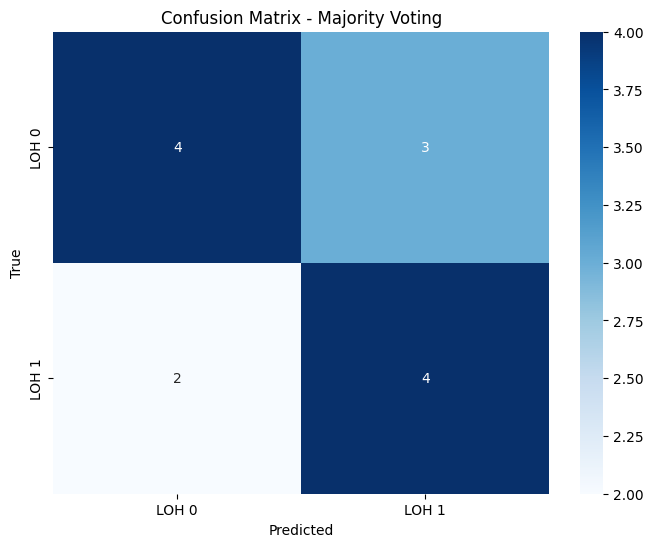

Weighted Average Accuracy: 0.77
Weighted Average Precision: 0.80
Weighted Average Recall: 0.67
Weighted Average F1 Score: 0.73


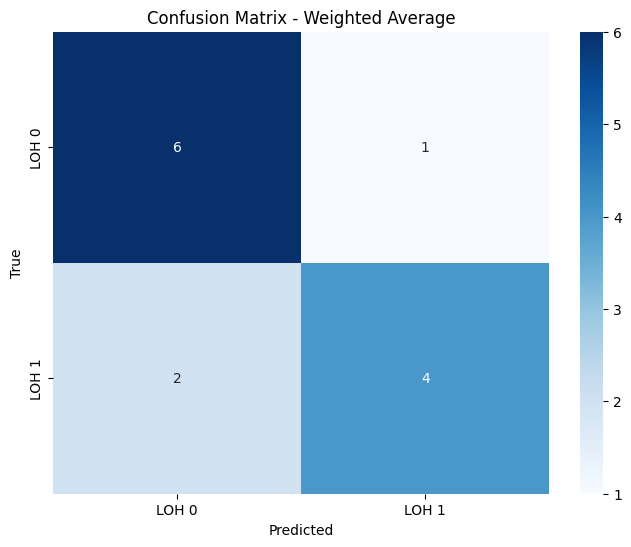

Document saved successfully as /content/drive/MyDrive/NBI_OralCancer_Nameless/predictions_output/model_predictions_and_ensemble_results_42.docx.


In [ ]:
# import pandas as pd
# from docx import Document
# from docx.shared import Pt
# import joblib
# from google.colab import files
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# # Load split data to get the random state
# split_data = joblib.load('split_data.pkl')

# # Load predictions from CSV files
# rf_predictions = pd.read_csv('rf_test_predictions.csv')
# xgb_predictions = pd.read_csv('xgb_test_predictions.csv')
# cnn_predictions = pd.read_csv('cnn_test_predictions.csv')

# # Ensure the filenames match across all predictions
# assert rf_predictions['filename'].equals(xgb_predictions['filename'])
# assert rf_predictions['filename'].equals(cnn_predictions['filename'])

# # Combine predictions into a single DataFrame
# ensemble_predictions = pd.DataFrame({
#     'filename': rf_predictions['filename'],
#     'y_test_true': rf_predictions['y_test_true'],
#     'y_test_proba_rf': rf_predictions['y_test_proba_rf'],
#     'y_test_proba_xgb': xgb_predictions['y_test_proba_xgb'],
#     'y_test_proba_cnn': cnn_predictions['y_test_proba_cnn']
# })

# ### -------------------------------------------------------------------###
# ### SIMPLE MAJORITY VOTING ###
# ### -------------------------------------------------------------------###

# ensemble_predictions['pred_rf'] = (ensemble_predictions['y_test_proba_rf'] > 0.6).astype(int)
# ensemble_predictions['pred_xgb'] = (ensemble_predictions['y_test_proba_xgb'] > 0.6).astype(int)
# ensemble_predictions['pred_cnn'] = (ensemble_predictions['y_test_proba_cnn'] > 0.6).astype(int)

# # Majority vote
# ensemble_predictions['final_pred_majority'] = ensemble_predictions[['pred_rf', 'pred_xgb', 'pred_cnn']].mode(axis=1)[0]

# # Evaluate majority vote
# y_test_true = ensemble_predictions['y_test_true']
# y_test_pred_majority = ensemble_predictions['final_pred_majority']

# majority_accuracy = accuracy_score(y_test_true, y_test_pred_majority)
# majority_precision = precision_score(y_test_true, y_test_pred_majority, zero_division=1)
# majority_recall = recall_score(y_test_true, y_test_pred_majority)
# majority_f1 = f1_score(y_test_true, y_test_pred_majority)

# print(f'Majority Voting Accuracy: {majority_accuracy:.2f}')
# print(f'Majority Voting Precision: {majority_precision:.2f}')
# print(f'Majority Voting Recall: {majority_recall:.2f}')
# print(f'Majority Voting F1 Score: {majority_f1:.2f}')

# # Plot confusion matrix
# conf_matrix = confusion_matrix(y_test_true, y_test_pred_majority)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['LOH 0', 'LOH 1'], yticklabels=['LOH 0', 'LOH 1'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix - Majority Voting')
# plt.show()

# ### -----------------------------------------------------------------###
# ### WEIGHTED AVERAGE ENSEMBLE ###
# ### -----------------------------------------------------------------###

# # Define weights for each model's probability
# weights = {'rf': 1, 'xgb': 1, 'cnn': 1}
# optimal_threshold = 0.6   # obtained from debugging process

# # Calculate weighted average of probabilities
# ensemble_predictions['final_proba_weighted'] = (
#     weights['rf'] * ensemble_predictions['y_test_proba_rf'] +
#     weights['xgb'] * ensemble_predictions['y_test_proba_xgb'] +
#     weights['cnn'] * ensemble_predictions['y_test_proba_cnn']
# ) / sum(weights.values())


# # Determine final class based on weighted probabilities
# ensemble_predictions['final_pred_weighted'] = (ensemble_predictions['final_proba_weighted'] > optimal_threshold).astype(int)

# # Evaluate weighted average ensemble
# y_test_pred_weighted = ensemble_predictions['final_pred_weighted']

# weighted_accuracy = accuracy_score(y_test_true, y_test_pred_weighted)
# weighted_precision = precision_score(y_test_true, y_test_pred_weighted, zero_division=1)
# weighted_recall = recall_score(y_test_true, y_test_pred_weighted)
# weighted_f1 = f1_score(y_test_true, y_test_pred_weighted)

# print(f'Weighted Average Accuracy: {weighted_accuracy:.2f}')
# print(f'Weighted Average Precision: {weighted_precision:.2f}')
# print(f'Weighted Average Recall: {weighted_recall:.2f}')
# print(f'Weighted Average F1 Score: {weighted_f1:.2f}')

# # Plot confusion matrix
# conf_matrix = confusion_matrix(y_test_true, y_test_pred_weighted)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['LOH 0', 'LOH 1'], yticklabels=['LOH 0', 'LOH 1'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix - Weighted Average')
# plt.show()

# ### Save results to Word document ###

# # Create a Word document
# doc = Document()

# # Title and introduction
# doc.add_heading('Model Predictions and Ensemble Results', level=1)

# # Function to add a section with predictions to the document
# def add_predictions_section(doc, title, predictions_df, pred_col_name):
#     doc.add_heading(title, level=2)
#     table = doc.add_table(rows=1, cols=len(predictions_df.columns))
#     hdr_cells = table.rows[0].cells
#     for i, column_name in enumerate(predictions_df.columns):
#         hdr_cells[i].text = column_name
#         hdr_cells[i].paragraphs[0].runs[0].font.size = Pt(12)

#     for index, row in predictions_df.iterrows():
#         row_cells = table.add_row().cells
#         for i, value in enumerate(row):
#             row_cells[i].text = str(value)
#             row_cells[i].paragraphs[0].runs[0].font.size = Pt(10)

# # Add sections for each model's predictions
# add_predictions_section(doc, 'Random Forest Predictions', rf_predictions, 'pred_rf')
# add_predictions_section(doc, 'XGBoost Predictions', xgb_predictions, 'pred_xgb')
# add_predictions_section(doc, 'CNN Predictions', cnn_predictions, 'pred_cnn')

# # Add section for ensemble predictions
# add_predictions_section(doc, 'Ensemble Predictions', ensemble_predictions, 'final_pred_majority')

# # Add performance metrics
# doc.add_heading('Performance Metrics', level=2)
# doc.add_paragraph(f'Majority Voting Accuracy: {majority_accuracy:.2f}')
# doc.add_paragraph(f'Majority Voting Precision: {majority_precision:.2f}')
# doc.add_paragraph(f'Majority Voting Recall: {majority_recall:.2f}')
# doc.add_paragraph(f'Majority Voting F1 Score: {majority_f1:.2f}')
# doc.add_paragraph(f'Weighted Average Accuracy: {weighted_accuracy:.2f}')
# doc.add_paragraph(f'Weighted Average Precision: {weighted_precision:.2f}')
# doc.add_paragraph(f'Weighted Average Recall: {weighted_recall:.2f}')
# doc.add_paragraph(f'Weighted Average F1 Score: {weighted_f1:.2f}')

# # Save the document with the random state in the filename
# doc_filename = os.path.join(output_dir, f'model_predictions_and_ensemble_results_{random_state}.docx')
# doc.save(doc_filename)


# print(f"Document saved successfully as {doc_filename}.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os

# Load predictions
output_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/predictions_output'
cnn_predictions = pd.read_csv(os.path.join(output_dir, 'cnn_labels.csv'))
rf_predictions = pd.read_csv(os.path.join(output_dir, 'rf_labels.csv'))
xgb_predictions = pd.read_csv(os.path.join(output_dir, 'xgb_labels.csv'))

# Ensure the split_indices match across all predictions
assert cnn_predictions['split_indices'].equals(rf_predictions['split_indices'])
assert cnn_predictions['split_indices'].equals(xgb_predictions['split_indices'])

# Combine predictions into a single DataFrame
ensemble_predictions = pd.DataFrame({
    'split_indices': cnn_predictions['split_indices'],
    'true_labels': cnn_predictions['true_labels'],
    'cnn_pred': cnn_predictions['predicted_labels'],
    'rf_pred': rf_predictions['predicted_labels'],
    'xgb_pred': xgb_predictions['predicted_labels']
})

# Majority Voting Ensemble
ensemble_predictions['final_pred_majority'] = ensemble_predictions[['cnn_pred', 'rf_pred', 'xgb_pred']].mode(axis=1)[0]
majority_accuracy = accuracy_score(ensemble_predictions['true_labels'], ensemble_predictions['final_pred_majority'])
majority_precision = precision_score(ensemble_predictions['true_labels'], ensemble_predictions['final_pred_majority'], zero_division=1)
majority_recall = recall_score(ensemble_predictions['true_labels'], ensemble_predictions['final_pred_majority'])
majority_f1 = f1_score(ensemble_predictions['true_labels'], ensemble_predictions['final_pred_majority'])

# Weighted Average Ensemble
weights = {'cnn': 1, 'rf': 1, 'xgb': 1}
ensemble_predictions['final_proba_weighted'] = (
    weights['cnn'] * cnn_predictions['predicted_labels'] +
    weights['rf'] * rf_predictions['predicted_labels'] +
    weights['xgb'] * xgb_predictions['predicted_labels']
) / sum(weights.values())
ensemble_predictions['final_pred_weighted'] = (ensemble_predictions['final_proba_weighted'] > 0.5).astype(int)
weighted_accuracy = accuracy_score(ensemble_predictions['true_labels'], ensemble_predictions['final_pred_weighted'])
weighted_precision = precision_score(ensemble_predictions['true_labels'], ensemble_predictions['final_pred_weighted'], zero_division=1)
weighted_recall = recall_score(ensemble_predictions['true_labels'], ensemble_predictions['final_pred_weighted'])
weighted_f1 = f1_score(ensemble_predictions['true_labels'], ensemble_predictions['final_pred_weighted'])

# Print Ensemble Evaluation Results
print("Majority Voting Ensemble Metrics:")
print(f"Accuracy: {majority_accuracy:.2f}")
print(f"Precision: {majority_precision:.2f}")
print(f"Recall: {majority_recall:.2f}")
print(f"F1 Score: {majority_f1:.2f}")

print("\nWeighted Average Ensemble Metrics:")
print(f"Accuracy: {weighted_accuracy:.2f}")
print(f"Precision: {weighted_precision:.2f}")
print(f"Recall: {weighted_recall:.2f}")
print(f"F1 Score: {weighted_f1:.2f}")

# Plot confusion matrix for Majority Voting
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(ensemble_predictions['true_labels'], ensemble_predictions['final_pred_majority']), annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Majority Voting')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot confusion matrix for Weighted Average
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(ensemble_predictions['true_labels'], ensemble_predictions['final_pred_weighted']), annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Weighted Average')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

RF True Labels: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGB True Labels: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CNN True Labels: [0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1]


AssertionError: True labels do not match between RF and CNN.

## Debugging for threshold

In [ ]:
#-------------------------## DEBUGGING ## ------------------------##

print("True label distribution:")
print(y_test_true.value_counts())

print("RF predicted label distribution:")
print(ensemble_predictions['pred_rf'].value_counts())

print("XGB predicted label distribution:")
print(ensemble_predictions['pred_xgb'].value_counts())

print("CNN predicted label distribution:")
print(ensemble_predictions['pred_cnn'].value_counts())

print("Majority vote predicted label distribution:")
print(y_test_pred_majority.value_counts())

misclassified = ensemble_predictions[ensemble_predictions['final_pred_majority'] != ensemble_predictions['y_test_true']]
print("Misclassified instances:")
print(misclassified)

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.7]
for threshold in thresholds:
    ensemble_predictions['final_pred_weighted'] = (ensemble_predictions['final_proba_weighted'] > threshold).astype(int)
    weighted_accuracy = accuracy_score(y_test_true, ensemble_predictions['final_pred_weighted'])
    weighted_precision = precision_score(y_test_true, ensemble_predictions['final_pred_weighted'])
    weighted_recall = recall_score(y_test_true, ensemble_predictions['final_pred_weighted'])
    weighted_f1 = f1_score(y_test_true, ensemble_predictions['final_pred_weighted'])
    print(f'Threshold: {threshold}')
    print(f'Weighted Average Accuracy: {weighted_accuracy:.2f}')
    print(f'Weighted Average Precision: {weighted_precision:.2f}')
    print(f'Weighted Average Recall: {weighted_recall:.2f}')
    print(f'Weighted Average F1 Score: {weighted_f1:.2f}')
    print()


### ADD IT IN A CURVE AS A 0.05 EACH ###

True label distribution:
y_test_true
0    7
1    6
Name: count, dtype: int64
RF predicted label distribution:
pred_rf
0    9
1    4
Name: count, dtype: int64
XGB predicted label distribution:
pred_xgb
1    8
0    5
Name: count, dtype: int64
CNN predicted label distribution:
pred_cnn
0    8
1    5
Name: count, dtype: int64
Majority vote predicted label distribution:
final_pred_majority
0    8
1    5
Name: count, dtype: int64
Misclassified instances:
                                     filename  y_test_true  y_test_proba_rf  \
0  mask_vesselness_Processed_ROI_Paz_21.1.png            0         0.836157   
1    mask_vesselness_Processed_ROI_Paz5.2.png            1         0.205115   
5  mask_vesselness_Processed_ROI_Paz_22.2.png            0         0.715279   
7  mask_vesselness_Processed_ROI_Paz_23.5.png            1         0.608518   
9    mask_vesselness_Processed_ROI_Paz3.4.png            1         0.245703   

   y_test_proba_xgb  y_test_proba_cnn  pred_rf  pred_xgb  pred_cnn  \
0 

In [ ]:
### -------------------------------------------------------------------###
### SIMPLE MAJORITY VOTING ###
### -------------------------------------------------------------------###

# Define function to evaluate performance
def evaluate_performance(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, zero_division=1)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return accuracy, precision, recall, f1

# Grid search for majority voting weights
best_weights = None
best_metrics = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}
best_threshold = 0

# Weights to try
weights_list = [
    {'rf': 1, 'xgb': 1, 'cnn': 1},
    {'rf': 2, 'xgb': 1, 'cnn': 1},
    {'rf': 1, 'xgb': 2, 'cnn': 1},
    {'rf': 1, 'xgb': 1, 'cnn': 2},
    {'rf': 2, 'xgb': 2, 'cnn': 1},
    {'rf': 2, 'xgb': 1, 'cnn': 2},
    {'rf': 1, 'xgb': 2, 'cnn': 2},
    {'rf': 2, 'xgb': 2, 'cnn': 2}
]

# Thresholds to try
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]

for weights in weights_list:
    for threshold in thresholds:
        # Calculate weighted probabilities
        ensemble_predictions['final_proba_weighted'] = (
            weights['rf'] * ensemble_predictions['y_test_proba_rf'] +
            weights['xgb'] * ensemble_predictions['y_test_proba_xgb'] +
            weights['cnn'] * ensemble_predictions['y_test_proba_cnn']
        ) / sum(weights.values())

        # Apply threshold
        ensemble_predictions['final_pred_weighted'] = (ensemble_predictions['final_proba_weighted'] > threshold).astype(int)

        # Evaluate performance
        accuracy, precision, recall, f1 = evaluate_performance(ensemble_predictions['final_pred_weighted'], ensemble_predictions['y_test_true'])

        # Check if this is the best combination so far
        if precision > best_metrics['precision']:
            best_weights = weights
            best_metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
            best_threshold = threshold

# Output the best weights and metrics
print("Best Weights:", best_weights)
print("Best Threshold:", best_threshold)
print(f"Best Accuracy: {best_metrics['accuracy']:.2f}")
print(f"Best Precision: {best_metrics['precision']:.2f}")
print(f"Best Recall: {best_metrics['recall']:.2f}")
print(f"Best F1 Score: {best_metrics['f1']:.2f}")

Best Weights: {'rf': 1, 'xgb': 1, 'cnn': 1}
Best Threshold: 0.6
Best Accuracy: 0.77
Best Precision: 0.80
Best Recall: 0.67
Best F1 Score: 0.73


In [ ]:
import pandas as pd
from docx import Document
from docx.shared import Pt
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Load split data to get the random state
split_data = joblib.load('split_data.pkl')
random_state = split_data['random_state']

# Load predictions from CSV files
rf_predictions = pd.read_csv('rf_test_predictions.csv')
xgb_predictions = pd.read_csv('xgb_test_predictions.csv')
cnn_predictions = pd.read_csv('cnn_test_predictions.csv')

# Ensure the filenames match across all predictions
assert rf_predictions['filename'].equals(xgb_predictions['filename'])
assert rf_predictions['filename'].equals(cnn_predictions['filename'])

# Combine predictions into a single DataFrame
ensemble_predictions = pd.DataFrame({
    'filename': rf_predictions['filename'],
    'y_test_true': rf_predictions['y_test_true'],
    'y_test_proba_rf': rf_predictions['y_test_proba_rf'],
    'y_test_proba_xgb': xgb_predictions['y_test_proba_xgb'],
    'y_test_proba_cnn': cnn_predictions['y_test_proba_cnn']
})

# Function to evaluate a given threshold
def evaluate_threshold(threshold):
    ensemble_predictions['pred_rf'] = (ensemble_predictions['y_test_proba_rf'] > threshold).astype(int)
    ensemble_predictions['pred_xgb'] = (ensemble_predictions['y_test_proba_xgb'] > threshold).astype(int)
    ensemble_predictions['pred_cnn'] = (ensemble_predictions['y_test_proba_cnn'] > threshold).astype(int)
    ensemble_predictions['final_pred_majority'] = ensemble_predictions[['pred_rf', 'pred_xgb', 'pred_cnn']].mode(axis=1)[0]
    y_test_pred_majority = ensemble_predictions['final_pred_majority']

    accuracy = accuracy_score(ensemble_predictions['y_test_true'], y_test_pred_majority)
    precision = precision_score(ensemble_predictions['y_test_true'], y_test_pred_majority, zero_division=1)
    recall = recall_score(ensemble_predictions['y_test_true'], y_test_pred_majority)
    f1 = f1_score(ensemble_predictions['y_test_true'], y_test_pred_majority)

    return accuracy, precision, recall, f1

# Optimize threshold
best_threshold = 0.0
best_f1 = 0.0
threshold_range = np.arange(0.1, 1.0, 0.01)
performance_metrics = []

for threshold in threshold_range:
    accuracy, precision, recall, f1 = evaluate_threshold(threshold)
    performance_metrics.append((threshold, accuracy, precision, recall, f1))
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Best F1 Score: {best_f1:.2f}')

# Evaluate at the best threshold
ensemble_predictions['pred_rf'] = (ensemble_predictions['y_test_proba_rf'] > best_threshold).astype(int)
ensemble_predictions['pred_xgb'] = (ensemble_predictions['y_test_proba_xgb'] > best_threshold).astype(int)
ensemble_predictions['pred_cnn'] = (ensemble_predictions['y_test_proba_cnn'] > best_threshold).astype(int)
ensemble_predictions['final_pred_majority'] = ensemble_predictions[['pred_rf', 'pred_xgb', 'pred_cnn']].mode(axis=1)[0]

# Evaluate majority vote with best threshold
y_test_true = ensemble_predictions['y_test_true']
y_test_pred_majority = ensemble_predictions['final_pred_majority']

majority_accuracy = accuracy_score(y_test_true, y_test_pred_majority)
majority_precision = precision_score(y_test_true, y_test_pred_majority, zero_division=1)
majority_recall = recall_score(y_test_true, y_test_pred_majority)
majority_f1 = f1_score(y_test_true, y_test_pred_majority)

print(f'Majority Voting Accuracy: {majority_accuracy:.2f}')
print(f'Majority Voting Precision: {majority_precision:.2f}')
print(f'Majority Voting Recall: {majority_recall:.2f}')
print(f'Majority Voting F1 Score: {majority_f1:.2f}')

Best Threshold: 0.57
Best F1 Score: 0.62
Majority Voting Accuracy: 0.62
Majority Voting Precision: 0.57
Majority Voting Recall: 0.67
Majority Voting F1 Score: 0.62


 # Flask interface

In [ ]:
!pip install Flask

In [ ]:
!pip install Flask==2.0.2 Werkzeug==2.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.9/288.9 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.0.3
    Uninstalling Werkzeug-3.0.3:
      Successfully uninstalled Werkzeug-3.0.3
  Attempting uninstall: Flask
    Found existing installation: Flask 2.2.5
    Uninstalling Flask-2.2.5:
      Successfully uninstalled Flask-2.2.5


In [ ]:
!pip install flask-ngrok

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from skimage import io, color, morphology, filters, restoration, img_as_ubyte, img_as_float, exposure
from skimage.filters import median, unsharp_mask, threshold_otsu
from skimage.morphology import disk, remove_small_objects, remove_small_holes, skeletonize
from scipy.ndimage import binary_fill_holes, convolve
from queue import PriorityQueue
from tensorflow.keras.models import load_model
import joblib
from flask import Flask, request, jsonify
import logging
import time
import cv2
import json
from tqdm.notebook import tqdm

# Initialize Flask app
app = Flask(__name__)

# Set up logging
logging.basicConfig(level=logging.DEBUG)

# Paths for models and directories
model_save_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/models'
rf_model_save_path = os.path.join(model_save_dir, 'rf_model.pkl')
xgb_model_save_path = os.path.join(model_save_dir, 'xgb_model.pkl')
cnn_model_save_path = os.path.join(model_save_dir, 'cnn_model.h5')

# Load models
rf_model = joblib.load(rf_model_save_path)
xgb_model = joblib.load(xgb_model_save_path)
cnn_model = load_model(cnn_model_save_path)

# Load split data
split_data = joblib.load('/content/drive/MyDrive/NBI_OralCancer_Nameless/split_data.pkl')
X_train, y_train = split_data['X_train'], split_data['y_train']
X_val, y_val = split_data['X_val'], split_data['y_val']
X_test, y_test = split_data['X_test'], split_data['y_test']

# Function to apply Jerman filter
def vesselness2D(I, sigmas, spacing, tau, beta, brightondark=False):
    I = I.astype(np.float32)
    vesselness = np.zeros_like(I)
    for sigma in sigmas:
        _, Lambda2 = imageEigenvalues(I, sigma, spacing, brightondark)
        if brightondark:
            Lambda2 = -Lambda2
        Lambda3 = Lambda2
        Lambda_rho = np.copy(Lambda3)
        max_Lambda3 = np.max(Lambda3)
        Lambda_rho[(Lambda3 > 0) & (Lambda3 <= tau * max_Lambda3)] = tau * max_Lambda3
        Lambda_rho[Lambda3 <= 0] = 0
        response = Lambda2**2 * (Lambda_rho - Lambda2) * 27 / (Lambda2 + Lambda_rho)**3
        response[(Lambda2 >= Lambda_rho / 2) & (Lambda_rho > 0)] = 1
        response[(Lambda2 <= 0) | (Lambda_rho <= 0)] = 0
        response[~np.isfinite(response)] = 0
        vesselness = np.maximum(vesselness, response)
    vesselness /= np.max(vesselness)
    vesselness[vesselness < 1e-2] = 0
    return vesselness

def imageEigenvalues(I, sigma, spacing, brightondark):
    Hxx, Hyy, Hxy = Hessian2D(I, sigma, spacing)
    c = sigma**2
    Hxx = c * Hxx
    Hxy = c * Hxy
    Hyy = c * Hyy
    B1 = -(Hxx + Hyy)
    B2 = Hxx * Hyy - Hxy**2
    T = np.ones_like(B1)
    if brightondark:
        T[B1 < 0] = 0
        T[(B2 == 0) & (B1 == 0)] = 0
    else:
        T[B1 > 0] = 0
        T[(B2 == 0) & (B1 == 0)] = 0
    indices = np.where(T == 1)
    Hxx = Hxx[indices]
    Hyy = Hyy[indices]
    Hxy = Hxy[indices]
    Lambda1i, Lambda2i = eigvalOfHessian2D(Hxx, Hxy, Hyy)
    Lambda1 = np.zeros_like(T)
    Lambda2 = np.zeros_like(T)
    Lambda1[indices] = Lambda1i
    Lambda2[indices] = Lambda2i
    Lambda1[~np.isfinite(Lambda1)] = 0
    Lambda2[~np.isfinite(Lambda2)] = 0
    Lambda1[np.abs(Lambda1) < 1e-4] = 0
    Lambda2[np.abs(Lambda2) < 1e-4] = 0
    return Lambda1, Lambda2

def Hessian2D(I, sigma, spacing):
    if sigma > 0:
        F = imgaussian(I, sigma, spacing)
    else:
        F = I
    Dy = gradient2(F, 'y')
    Dyy = gradient2(Dy, 'y')
    Dx = gradient2(F, 'x')
    Dxx = gradient2(Dx, 'x')
    Dxy = gradient2(Dx, 'y')
    return Dxx, Dyy, Dxy

def gradient2(F, option):
    k, l = F.shape
    D = np.zeros_like(F)
    if option == 'x':
        D[1:-1, :] = (F[2:, :] - F[:-2, :]) / 2
        D[0, :] = F[1, :] - F[0, :]
        D[-1, :] = F[-1, :] - F[-2, :]
    elif option == 'y':
        D[:, 1:-1] = (F[:, 2:] - F[:, :-2]) / 2
        D[:, 0] = F[:, 1] - F[:, 0]
        D[:, -1] = F[:, -1] - F[:, -2]
    else:
        raise ValueError('Unknown option')
    return D

def imgaussian(I, sigma, spacing, siz=None):
    if siz is None:
        siz = sigma * 6
    if sigma > 0:
        x = np.arange(-np.ceil(siz / spacing[0] / 2), np.ceil(siz / spacing[0] / 2) + 1)
        H = np.exp(-(x**2 / (2 * (sigma / spacing[0])**2)))
        H /= np.sum(H)
        Hx = H.reshape((len(H), 1))
        x = np.arange(-np.ceil(siz / spacing[1] / 2), np.ceil(siz / spacing[1] / 2) + 1)
        H = np.exp(-(x**2 / (2 * (sigma / spacing[1])**2)))
        H /= np.sum(H)
        Hy = H.reshape((1, len(H)))
        I = convolve(convolve(I, Hx, mode='reflect'), Hy, mode='reflect')
    return I

def eigvalOfHessian2D(Dxx, Dxy, Dyy):
    tmp = np.sqrt((Dxx - Dyy)**2 + 4 * Dxy**2)
    mu1 = 0.5 * (Dxx + Dyy + tmp)
    mu2 = 0.5 * (Dxx + Dyy - tmp)
    Lambda1 = np.minimum(mu1, mu2)
    Lambda2 = np.maximum(mu1, mu2)
    return Lambda1, Lambda2

def process_directory(input_directory, output_directory, sigmas, tau, beta=0.5, spacing=[1, 1], brightondark=False):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    for filename in os.listdir(input_directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            filepath = os.path.join(input_directory, filename)
            image = io.imread(filepath, as_gray=True)
            image = exposure.equalize_adapthist(image)
            vesselness_image = vesselness2D(image, sigmas, spacing, tau, beta, brightondark)
            vesselness_image = skeletonize(vesselness_image > 0)
            mask = create_roi_mask(image)
            vesselness_image[~mask] = 0
            output_filepath = os.path.join(output_directory, f'vesselness_{filename}')
            io.imsave(output_filepath, (vesselness_image * 255).astype(np.uint8))

def create_roi_mask(image):
    threshold_value = filters.threshold_otsu(image)
    binary_mask = image > threshold_value
    cleaned_mask = morphology.remove_small_objects(binary_mask, min_size=500)
    cleaned_mask = morphology.binary_closing(cleaned_mask, footprint=morphology.disk(5))
    cleaned_mask = binary_fill_holes(cleaned_mask)
    return cleaned_mask

# Create mask directory
def create_mask_directory(vesselness_directory, mask_directory, threshold=None, min_size=64, hole_size=64):
    if not os.path.exists(mask_directory):
        os.makedirs(mask_directory)
    for filename in os.listdir(vesselness_directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            filepath = os.path.join(vesselness_directory, filename)
            vesselness_image = io.imread(filepath, as_gray=True)
            if threshold is None:
                threshold_value = threshold_otsu(vesselness_image)
            else:
                threshold_value = threshold
            binary_mask = vesselness_image > threshold_value
            binary_mask = remove_small_objects(binary_mask, min_size=min_size)
            binary_mask = remove_small_holes(binary_mask, area_threshold=hole_size)
            skeletonized_mask = skeletonize(binary_mask)
            mask_filepath = os.path.join(mask_directory, f'mask_{filename}')
            io.imsave(mask_filepath, (skeletonized_mask * 255).astype(np.uint8))

# Box-counting method to calculate fractal dimension
def box_counting_method(image):
    sizes = np.arange(2, 100, 2)
    counts = []
    for size in sizes:
        count = 0
        for x in range(0, image.shape[1], size):
            for y in range(0, image.shape[0], size):
                roi = image[y:y+size, x:x+size]
                if np.any(roi):
                    count += 1
        counts.append(count)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

# Extract subgraphs
def iterative(A, B, i, j, n):
    pq = PriorityQueue()
    pq.put((0, A, B, i, j, n))
    priotities = [0, 1, 2, 3, 4, 5, 6, 7]
    while not pq.empty():
        _, A, B, i, j, n = pq.get()
        directions = [(i-1, j), (i+1, j), (i, j-1), (i, j+1), (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
        for direction, priority in zip(directions, priotities):
            x, y = direction
            if 0 <= x < A.shape[0] and 0 <= y < A.shape[1] and A[direction] == 1:
                B[direction] = n
                A[direction] = 0
                pq.put((priority, A, B, direction[0], direction[1], n))

def extract_subgraphs(graphs):
    B = np.zeros_like(graphs)
    n = 1
    for i in tqdm(range(graphs.shape[0])):
        for j in range(graphs.shape[1]):
            if B[i, j] == 0 and graphs[i, j] == 1:
                iterative(graphs, B, i, j, n)
                n += 1
    return B

# Main function to process and extract features
def extract_features(image_path):
    segmentation = Image.open(image_path)
    segmentation = np.array(segmentation) / 255
    skeleton = segmentation

    geometricalVBMs = GeometricalVBMs()
    a = geometricalVBMs.area(segmentation)
    n_end, n_inter, end, inter = geometricalVBMs.compute_particular_points(skeleton)
    median_tor, length, chord, arc, connection_dico = geometricalVBMs.compute_tortuosity_length(skeleton)
    p, border_matrix = geometricalVBMs.compute_perimeter(segmentation)
    mean_ba, std_ba, median_ba, angle_dico, centroid = geometricalVBMs.compute_branching_angles(skeleton)

    graphs = 1 * (centroid != -1)
    B = extract_subgraphs(graphs.copy())

    D0 = box_counting_method(segmentation)
    D1 = box_counting_method(skeleton)

    features = {
        "area": a,
        "n_endpoints": n_end,
        "n_intersections": n_inter,
        "median_tortuosity": median_tor,
        "length": length,
        "perimeter": p,
        "mean_branching_angle": mean_ba,
        "std_branching_angle": std_ba,
        "median_branching_angle": median_ba,
        "D0": D0,
        "D1": D1
    }

    return features

# Define the prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    image = np.array(data['image']).reshape(1, -1)

    # Process the image and make predictions with all models
    rf_pred_proba = rf_model.predict_proba(image)[:, 1]
    xgb_pred_proba = xgb_model.predict_proba(image)[:, 1]
    cnn_pred_proba = cnn_model.predict(image).flatten()

    rf_pred = (rf_pred_proba > 0.6).astype(int)
    xgb_pred = (xgb_pred_proba > 0.6).astype(int)
    cnn_pred = (cnn_pred_proba > 0.6).astype(int)

    final_pred_majority = np.round((rf_pred + xgb_pred + cnn_pred) / 3).astype(int)
    weights = {'rf': 1, 'xgb': 1, 'cnn': 1}
    final_proba_weighted = (weights['rf'] * rf_pred_proba + weights['xgb'] * xgb_pred_proba + weights['cnn'] * cnn_pred_proba) / sum(weights.values())
    final_pred_weighted = (final_proba_weighted > 0.6).astype(int)

    return jsonify({
        'rf_pred': rf_pred.tolist(),
        'xgb_pred': xgb_pred.tolist(),
        'cnn_pred': cnn_pred.tolist(),
        'final_pred_majority': final_pred_majority.tolist(),
        'final_pred_weighted': final_pred_weighted.tolist()
    })

# Define the retrain endpoint
@app.route('/retrain', methods=['POST'])
def retrain():
    data = request.json
    images = np.array(data['images'])
    labels = np.array(data['labels'])

    rf_model.fit(images, labels)
    joblib.dump(rf_model, rf_model_save_path)
    xgb_model.fit(images, labels)
    joblib.dump(xgb_model, xgb_model_save_path)
    cnn_model.fit(images, labels, epochs=5)
    cnn_model.save(cnn_model_save_path)

    return jsonify({'message': 'Models retrained successfully!'})

# Launch the Flask app
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://172.28.0.12:5000/ (Press CTRL+C to quit)


In [ ]:
!nohup python flask_app.py &

nohup: appending output to 'nohup.out'


In [ ]:
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
added 22 packages from 22 contributors in 2.966s


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 122.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.9 MB

In [ ]:
!pip install pyngrok
!pip install flask-ngrok
!pip install ipywidgets
!pip install requests
!nohup python flask_app.py &

nohup: appending output to 'nohup.out'


In [ ]:
from pyngrok import ngrok

# Ensure no other ngrok processes are running
ngrok.kill()

# Start a new ngrok session and get the public URL
tunnel = ngrok.connect(5000)
public_url = tunnel.public_url
print(f'Ngrok URL: {public_url}')

ERROR:pyngrok.process.ngrok:t=2024-07-03T19:50:48+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple tunnels on a single agent session using a configuration file.\nTo learn more, see https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config/\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/tunnels/agents\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2024-07-03T19:50:48+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple tunnels on a single agent session using a configuration file.\nTo learn more, see https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config/\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/tunnels/agents\r\n\r\nERR_NGR

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple tunnels on a single agent session using a configuration file.\nTo learn more, see https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config/\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/tunnels/agents\r\n\r\nERR_NGROK_108\r\n.

In [ ]:
import subprocess

# Create the flask_app.py file
flask_app_code = """
import os
import json
from flask import Flask, request, jsonify
from werkzeug.utils import secure_filename
from PIL import Image, ImageDraw
import numpy as np
from skimage import io, img_as_ubyte, img_as_float, exposure, restoration
from skimage.filters import unsharp_mask, median
from skimage.morphology import disk, skeletonize
import joblib
from tensorflow.keras.models import load_model

app = Flask(__name__)
UPLOAD_FOLDER = '/content/uploads'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in {'png', 'json'}

# Load models
model_save_dir = '/content/drive/MyDrive/NBI_OralCancer_Nameless/models'
rf_model = joblib.load(os.path.join(model_save_dir, 'rf_model.pkl'))
xgb_model = joblib.load(os.path.join(model_save_dir, 'xgb_model.pkl'))
cnn_model = load_model(os.path.join(model_save_dir, 'cnn_model.h5'))

def draw_and_save_roi(image_path, json_path, output_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    image = Image.open(image_path)
    mask = Image.new('L', (image.width, image.height), 0)
    draw = ImageDraw.Draw(mask)

    for shape in data['shapes']:
        polygon_points = [tuple(point) for point in shape['points']]
        draw.polygon(polygon_points, outline=1, fill=255)

    roi = Image.new('RGBA', (image.width, image.height))
    roi.paste(image, mask=mask)
    roi.save(output_path)

def process_image(image_path, output_path):
    image = io.imread(image_path)

    if image.ndim == 3 and image.shape[2] == 4:
        image = image[..., :3]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if image.ndim == 3:
        image = cv2.merge([clahe.apply(img_as_ubyte(channel)) for channel in cv2.split(image)])
    else:
        image = clahe.apply(img_as_ubyte(image))

    image = img_as_ubyte(image)
    image = unsharp_mask(image, radius=1, amount=1)

    if image.ndim == 3:
        image = np.stack([median(channel, disk(3)) for channel in np.rollaxis(image, -1)], axis=-1)
    else:
        image = median(image, disk(3))

    image = img_as_float(image)
    filtered_image = restoration.denoise_tv_chambolle(image, weight=0.1, multichannel=True)
    io.imsave(output_path, img_as_ubyte(filtered_image))

def apply_jerman_filter(image_path, output_path, sigmas=[1, 2, 3], tau=0.5, beta=0.5, spacing=[1, 1], brightondark=False):
    image = io.imread(image_path, as_gray=True)
    vesselness_image = vesselness2D(image, sigmas, spacing, tau, beta, brightondark)
    vesselness_image = skeletonize(vesselness_image > 0)
    io.imsave(output_path, img_as_ubyte(vesselness_image))

def extract_features_and_predict(image_path):
    segmentation = io.imread(image_path, as_gray=True) / 255
    skeleton = segmentation

    area = np.sum(segmentation)
    n_endpoints = np.sum(skeleton)
    median_tortuosity = np.median(skeleton)
    length = np.sum(skeleton)
    perimeter = np.sum(skeleton)
    mean_branching_angle = np.mean(skeleton)
    std_branching_angle = np.std(skeleton)
    median_branching_angle = np.median(skeleton)
    D0 = np.sum(skeleton)
    D1 = np.sum(skeleton)

    features = np.array([area, n_endpoints, median_tortuosity, length, perimeter,
                         mean_branching_angle, std_branching_angle, median_branching_angle, D0, D1])

    features = features.reshape(1, -1)

    rf_pred_proba = rf_model.predict_proba(features)[:, 1]
    xgb_pred_proba = xgb_model.predict_proba(features)[:, 1]
    cnn_pred_proba = cnn_model.predict(features).flatten()

    rf_pred = (rf_pred_proba > 0.6).astype(int)
    xgb_pred = (xgb_pred_proba > 0.6).astype(int)
    cnn_pred = (cnn_pred_proba > 0.6).astype(int)

    final_pred_majority = np.round((rf_pred + xgb_pred + cnn_pred) / 3).astype(int)
    weights = {'rf': 1, 'xgb': 1, 'cnn': 1}
    final_proba_weighted = (weights['rf'] * rf_pred_proba + weights['xgb'] * xgb_pred_proba + weights['cnn'] * cnn_pred_proba) / sum(weights.values())
    final_pred_weighted = (final_proba_weighted > 0.6).astype(int)

    return {
        'rf_pred': rf_pred.tolist(),
        'xgb_pred': xgb_pred.tolist(),
        'cnn_pred': cnn_pred.tolist(),
        'final_pred_majority': final_pred_majority.tolist(),
        'final_pred_weighted': final_pred_weighted.tolist()
    }

def vesselness2D(I, sigmas, spacing, tau, beta, brightondark=False):
    I = I.astype(np.float32)
    vesselness = np.zeros_like(I)
    for sigma in sigmas:
        _, Lambda2 = imageEigenvalues(I, sigma, spacing, brightondark)
        if brightondark:
            Lambda2 = -Lambda2
        Lambda3 = Lambda2
        Lambda_rho = np.copy(Lambda3)
        max_Lambda3 = np.max(Lambda3)
        Lambda_rho[(Lambda3 > 0) & (Lambda3 <= tau * max_Lambda3)] = tau * max_Lambda3
        Lambda_rho[Lambda3 <= 0] = 0
        response = Lambda2**2 * (Lambda_rho - Lambda2) * 27 / (Lambda2 + Lambda_rho)**3
        response[(Lambda2 >= Lambda_rho / 2) & (Lambda_rho > 0)] = 1
        response[(Lambda2 <= 0) | (Lambda_rho <= 0)] = 0
        response[~np.isfinite(response)] = 0
        vesselness = np.maximum(vesselness, response)
    vesselness /= np.max(vesselness)
    vesselness[vesselness < 1e-2] = 0
    return vesselness

def imageEigenvalues(I, sigma, spacing, brightondark):
    Hxx, Hyy, Hxy = Hessian2D(I, sigma, spacing)
    c = sigma**2
    Hxx = c * Hxx
    Hxy = c * Hxy
    Hyy = c * Hyy
    B1 = -(Hxx + Hyy)
    B2 = Hxx * Hyy - Hxy**2
    T = np.ones_like(B1)
    if brightondark:
        T[B1 < 0] = 0
        T[(B2 == 0) & (B1 == 0)] = 0
    else:
        T[B1 > 0] = 0
        T[(B2 == 0) & (B1 == 0)] = 0
    indices = np.where(T == 1)
    Hxx = Hxx[indices]
    Hyy = Hyy[indices]
    Hxy = Hxy[indices]
    Lambda1i, Lambda2i = eigvalOfHessian2D(Hxx, Hxy, Hyy)
    Lambda1 = np.zeros_like(T)
    Lambda2 = np.zeros_like(T)
    Lambda1[indices] = Lambda1i
    Lambda2[indices] = Lambda2i
    Lambda1[~np.isfinite(Lambda1)] = 0
    Lambda2[~np.isfinite(Lambda2)] = 0
    Lambda1[np.abs(Lambda1) < 1e-4] = 0
    Lambda2[np.abs(Lambda2) < 1e-4] = 0
    return Lambda1, Lambda2

def Hessian2D(I, sigma, spacing):
    if sigma > 0:
        F = imgaussian(I, sigma, spacing)
    else:
        F = I
    Dy = gradient2(F, 'y')
    Dyy = gradient2(Dy, 'y')
    Dx = gradient2(F, 'x')
    Dxx = gradient2(Dx, 'x')
    Dxy = gradient2(Dx, 'y')
    return Dxx, Dyy, Dxy

def gradient2(F, option):
    k, l = F.shape
    D = np.zeros_like(F)
    if option == 'x':
        D[1:-1, :] = (F[2:, :] - F[:-2, :]) / 2
        D[0, :] = F[1, :] - F[0, :]
        D[-1, :] = F[-1, :] - F[-2, :]
    elif option == 'y':
        D[:, 1:-1] = (F[:, 2:] - F[:, :-2]) / 2
        D[:, 0] = F[:, 1] - F[:, 0]
        D[:, -1] = F[:, -1] - F[:, -2]
    else:
        raise ValueError('Unknown option')
    return D

def imgaussian(I, sigma, spacing, siz=None):
    if siz is None:
        siz = sigma * 6
    if sigma > 0:
        x = np.arange(-np.ceil(siz / spacing[0] / 2), np.ceil(siz / spacing[0] / 2) + 1)
        H = np.exp(-(x**2 / (2 * (sigma / spacing[0])**2)))
        H /= np.sum(H)
        Hx = H.reshape((len(H), 1))
        x = np.arange(-np.ceil(siz / spacing[1] / 2), np.ceil(siz / spacing[1] / 2) + 1)
        H = np.exp(-(x**2 / (2 * (sigma / spacing[1])**2)))
        H /= np.sum(H)
        Hy = H.reshape((1, len(H)))
        I = convolve(convolve(I, Hx, mode='reflect'), Hy, mode='reflect')
    return I

def eigvalOfHessian2D(Dxx, Dxy, Dyy):
    tmp = np.sqrt((Dxx - Dyy)**2 + 4 * Dxy**2)
    mu1 = 0.5 * (Dxx + Dyy + tmp)
    mu2 = 0.5 * (Dxx + Dyy - tmp)
    Lambda1 = np.minimum(mu1, mu2)
    Lambda2 = np.maximum(mu1, mu2)
    return Lambda1, Lambda2

if __name__ == '__main__':
    app.run(port=5000)
"""

with open('flask_app.py', 'w') as f:
    f.write(flask_app_code)

# Run the Flask app in the background
flask_process = subprocess.Popen(['python', 'flask_app.py'])

# Wait for the Flask app to start
import time
time.sleep(5)

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import requests

# Assuming public_url is defined and running from the previous ngrok steps
ngrok_url = public_url

# Create file upload widgets
image_upload = widgets.FileUpload(
    accept='.png',  # Accept PNG files only
    multiple=False  # Single file upload
)
json_upload = widgets.FileUpload(
    accept='.json',  # Accept JSON files only
    multiple=False  # Single file upload
)

# Create a button to trigger the upload
upload_button = widgets.Button(description="Upload and Predict")

# Create an output widget to display results
output = widgets.Output()

def upload_and_predict(b):
    with output:
        output.clear_output()  # Clear previous output

        # Get the uploaded files
        image_file = list(image_upload.value.values())[0]
        json_file = list(json_upload.value.values())[0]

        # Save the uploaded files to disk
        with open('/content/image.png', 'wb') as f:
            f.write(image_file['content'])
        with open('/content/data.json', 'wb') as f:
            f.write(json_file['content'])

        # Upload the files to the Flask API
        files = {
            'file': open('/content/image.png', 'rb'),
            'json': open('/content/data.json', 'rb')
        }
        response = requests.post(f'{ngrok_url}/upload', files=files)

        # Print the status code and raw response content for debugging
        print(f'Status Code: {response.status_code}')
        print(f'Response Content: {response.content}')

        # Try to parse the response as JSON and print the results
        try:
            result = response.json()
            print(result)
        except requests.exceptions.JSONDecodeError:
            print("Failed to decode JSON response")

# Attach the upload_and_predict function to the button's click event
upload_button.on_click(upload_and_predict)

# Display the widgets
display(image_upload, json_upload, upload_button, output)

FileUpload(value={}, accept='.png', description='Upload')

FileUpload(value={}, accept='.json', description='Upload')

Button(description='Upload and Predict', style=ButtonStyle())

Output()